In [ ]:
# !pip install markdown
# !pip install --upgrade kaleido

### ⚙️ Cell 1: Technical Setup
This cell imports the required Python libraries, suppresses warnings for a cleaner output, and sets a consistent style for plots and data formatting. The "✅ Setup complete" message confirms the environment is ready.

In [1]:
# --- Technical Setup ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from typing import Dict, List, Optional, Tuple

# Ignore warnings for a cleaner executive report
warnings.filterwarnings('ignore')

# Set plotting style and display options
sns.set_style("whitegrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
print("✅ Setup complete.")

✅ Setup complete.


### ⚙️ Cell 1: Pipeline & Environment Setup
This cell imports all necessary tools for the analysis. It loads custom classes, simulation pipelines, and plotting functions from the `capacity_pipeline.py` script. It also prepares the notebook by importing standard libraries (pandas, numpy, etc.) and configuring display settings for clarity. The "✅ Setup complete" message confirms all components are loaded.

In [2]:
# --- Corrected Cell 1: Updated Imports ---

# Explicitly import all the necessary components from your consolidated .py file
from capacity_pipeline import (
    # Config & core classes
    ColumnMap, ScoreConfig, WSIConfig, ScenarioConfig, OptimizeConfig,
    DataPrep, CapacityScorer, WSIComputer,

    # WSI + sample data
    compute_capacity_centric_wsi, make_sample_data,

    # Simulation pipelines
    pre_post_tree_pipeline,                  # original consolidated simulator
    pre_post_tree_pipeline_cap_cases,        # cap + numCases (now supports causal sequence)

    # Model fit/predict helpers (direct and causal)
    fit_tree_models_from_features,           # trains per-target models using chosen features
    predict_post_from_cap_and_cases,         # predicts targets from Capacity + numCases + StaffGroup
    fit_tree_models_causal,                  # trains stage-wise (backlog → dtc → efficiency → WSI)
    predict_post_from_cap_cases_causal,      # sequential post predictions in causal order

    # Optimizer
    run_optimizer_pipeline,

    # Plots
    plot_score_distributions, plot_team_metrics, plot_feature_importances,
    plot_contributions_waterfall, plot_optimization_plan,
    plot_simulation_distributions, plot_bucket_uplift_distributions,
    plot_volume_uplift_distributions,
    plot_color_grid,                         # original table-like grid
    plot_color_grid_with_sanity,             # table grid with sanity IQR highlighting

    #Bootstrap
    run_simulation_bootstrap,

    build_contributions_df, build_wsi_contributions_df, _mstart
)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from typing import Dict, List, Optional, Tuple

# Ignore warnings for a cleaner executive report
warnings.filterwarnings('ignore')

# Set plotting style and display options
sns.set_style("whitegrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
print("✅ Setup complete with all consolidated components imported.")

✅ Setup complete with all consolidated components imported.


### 🔧 Analysis Configuration
This cell customizes the pipeline's parameters. It **maps your dataset's column names** to the pipeline's expected inputs (e.g., `TasksCompleted` becomes the primary `num_cases` metric). It then defines the **features for the Capacity Score**, their relative **weights**, and sets a "guardrail" to ensure scores don't fall below 20. Finally, it configures the goals for the **optimization engine**, specifying which outcomes to prioritize.

In [3]:


"""
This script consolidates all the configuration settings for the analytics pipeline.
It defines column mappings, feature lists, and configuration objects for scoring,
WSI calculation, simulations, and optimization.
"""

# It is assumed that these classes are available from your pipeline script.
from capacity_pipeline import (
    ColumnMap,
    ScoreConfig,
    WSIConfig,
    ScenarioConfig,
    OptimizeConfig
)

# --- Primary Configuration Settings ---

# 1. Defines the column names in your data.
cols = ColumnMap(
    date="_date_",
    alias="alias",
    group="StaffGroup",
    num_cases="TasksCompleted",
    backlog="BacklogSize",
    avg_dtc="AvgTimeToResolve",
    efficiency_raw="EfficiencyRating"
)

# 2. Defines the feature columns to be used in models.
#    This is now the single source of truth for feature lists.
my_feature_columns = [
    "TasksCompleted", "ActiveCases", "BacklogSize", "AvgTimeToResolve",
    "TenureInMonths", "EfficiencyRating", "CustomerSatisfaction"
]

capacity_features = [
    "TasksCompleted", "ActiveCases", "BacklogSize", "AvgTimeToResolve",
    "TenureInMonths", "EfficiencyRating", "CustomerSatisfaction"
]


# Defines the desired direction of impact for each feature (True = higher is worse).
my_feature_direction = {
    "TasksCompleted": False, "ActiveCases": True, "BacklogSize": True,
    "AvgTimeToResolve": True, "TenureInMonths": False, "EfficiencyRating": False,
    "CustomerSatisfaction": False
}

# 3. Defines feature weights for the percentile-based Capacity Score.
feature_weights = {
    'TasksCompleted': 0.4,
    'EfficiencyRating': 0.3,
    'AvgTimeToResolve': 0.2,
    'BacklogSize': 0.1
}

# 4. Config for the Capacity Score.
score_cfg = ScoreConfig(
    method="percentile",
    direction_map=my_feature_direction,
    random_state=42,
    score_range=(20, 100),
    percentile_weights=feature_weights
)

# 5. Config for the Workload Saturation Index (WSI).
wsi_cfg = WSIConfig(
    team_aggregate="mean",
    distribution="gaussian",
    feature_range=(20, 100),
    weights=dict(
        w_workload=0.50,
        cap_dev=0.10,
        persist=0.15,
        complexity=0.15,
        time=0.10
    )
)

# 6. Config for "What-If" Scenarios and derived metric names.
CAPACITY_SCORE_COL = "Capacity_Score_0_100"
scn_cfg = ScenarioConfig(capacity_col_out=CAPACITY_SCORE_COL, random_state=42)

# 7. Config for the Optimizer.
WSI_COL = "WSI_0_100"
EFFICIENCY_COL = "efficiency"
DTC_COL = "days_to_close"
opt_cfg = OptimizeConfig(
    budget_moves=15,
    objective_weights={
        WSI_COL: -1.0,
        EFFICIENCY_COL: +0.6,
        DTC_COL: -0.6,
        cols.backlog: -0.8,
        cols.num_cases: +0.25
    },
    random_state=42
)

# Define the targets for the OutcomeModeler dynamically
modeler_targets = (WSI_COL, EFFICIENCY_COL, DTC_COL, cols.backlog)


print("✅ Unified configuration loaded from analysis_config.py")




✅ Unified configuration loaded from analysis_config.py


### 📊 Score Generation
This cell executes the core scoring pipeline. It first **generates a sample dataset** and then processes it in three stages:

1.  **Data Prep**: It standardizes the raw data by comparing each employee's performance against their team's benchmark.
2.  **Capacity Scoring**: It computes the **Capacity Score (0-100)** for each employee based on the prepared features and configured weights.
3.  **WSI Calculation**: It calculates the **Workload-Strain Index (WSI)** to measure potential stress for both individuals and teams.

The output table previews the final dataset, now enriched with the calculated `Capacity_Score_0_100` and `WSI_0_100`.

In [4]:
# --- Corrected Cell 4: Load Data and Calculate Scores ---
#
# Here, we generate our sample monthly data and run the core pipeline to calculate the
# Capacity Score and Workload Stress Index (WSI) for every employee and team.

# 1. Generate sample data for three months
df_full = make_sample_data(n_groups=4, aliases_per_group=30, months=["2025-06", "2025-07", "2025-08"])
df_full['efficiency'] = df_full['som'] # Use coalesce_names logic
df_full['days_to_close'] = df_full['avgDaysToClose']

# 2. Prepare the data (calculate deviations from benchmark)
prep = DataPrep(columns=cols, features=capacity_features, config=score_cfg).fit(df_full)
df_prepped = prep.transform(df_full)

# 3. Calculate the 0-100 Capacity Score for each employee-month
scorer = CapacityScorer(config=score_cfg).fit(df_prepped, group_col=cols.group, id_cols=(cols.alias, cols.date))
scores = scorer.transform(df_prepped, group_col=cols.group, id_cols=(cols.alias, cols.date))

# FIX: Merge only the new score column to avoid creating duplicate 'StaffGroup_x/y' columns.
df_scored = df_full.merge(
    scores[[cols.alias, cols.date, 'Capacity_Score_0_100']],
    on=[cols.alias, cols.date],
    how="left"
)

# 4. Calculate the 0-100 WSI for each employee-month and aggregate for teams
wsi_computer = WSIComputer(columns=cols, config=wsi_cfg)
wsi_results = wsi_computer.compute(df_scored)
alias_metrics = wsi_results["alias_metrics"]
team_metrics = wsi_results["team_metrics"]

print("✅ All scores calculated successfully.")
display(alias_metrics.head())

✅ All scores calculated successfully.


,alias,StaffGroup,_date_,Capacity_Score_0_100,WSI_0_100,cap_dev,complexity
0,SG-A-E01,SG-A,2025-06-01,68.28,64.05,1.00,0.06
1,SG-A-E01,SG-A,2025-07-01,69.57,60.74,1.00,0.07
2,SG-A-E01,SG-A,2025-08-01,68.90,33.87,0.00,0.06
3,SG-A-E02,SG-A,2025-06-01,27.14,59.81,0.00,0.09
4,SG-A-E02,SG-A,2025-07-01,26.44,44.66,0.00,0.04


### 🔍 Score Contribution Analysis
This cell explains the "why" behind each employee's Capacity Score. It runs the `build_contributions_df` function to break down each score into the individual contributions of its underlying features (e.g., `TasksCompleted`, `EfficiencyRating`). The output table shows which factors had the most positive or negative impact on an employee's score, clarifying the main drivers of their performance.

In [5]:
# ========= Build Capacity contributions (capacity_contributions_df) =========
contributions_df = build_contributions_df(
    df_prepped=df_prepped,
    df_full=df_full,
    scores=scores,
    scorer=scorer,
    score_cfg=score_cfg,
    cols=cols,
    capacity_features=capacity_features,
    top_k=None  # or e.g. 15
)

# Normalize month col
contributions_df["_date_"] = pd.to_datetime(contributions_df["_date_"], errors="coerce").dt.to_period("M").dt.to_timestamp()

# ---- OPTIONAL: focus on one alias first, then pick that alias's latest month ----
alias_to_show = "SG-A-E01"   # <<< change or set to None to skip alias filtering
cap_filtered = contributions_df.copy()

if alias_to_show is not None:
    cap_filtered = cap_filtered[cap_filtered[cols.alias] == alias_to_show].copy()
    if cap_filtered.empty:
        print(f"⚠️ No Capacity contributions found for alias '{alias_to_show}'. Showing ALL aliases' latest month instead.")
        cap_filtered = contributions_df.copy()

latest_month_contribs = cap_filtered["_date_"].max()
print("Latest Capacity month (after alias filter):", latest_month_contribs)
contributions_df_latest = cap_filtered[cap_filtered["_date_"] == latest_month_contribs].copy()
print(f"✅ Capacity contributions — {len(contributions_df_latest):,} rows for {latest_month_contribs:%Y-%m}")
display(contributions_df_latest)


Latest Capacity month (after alias filter): 2025-08-01 00:00:00
✅ Capacity contributions — 7 rows for 2025-08


,alias,_date_,StaffGroup,feature,contribution,Capacity_Score_0_100
15,SG-A-E01,2025-08-01,SG-A,TasksCompleted,2.86,68.90
17,SG-A-E01,2025-08-01,SG-A,AvgTimeToResolve,1.41,68.90
18,SG-A-E01,2025-08-01,SG-A,ActiveCases,0.17,68.90
19,SG-A-E01,2025-08-01,SG-A,CustomerSatisfaction,0.11,68.90
20,SG-A-E01,2025-08-01,SG-A,EfficiencyRating,-0.00,68.90
16,SG-A-E01,2025-08-01,SG-A,TenureInMonths,-2.06,68.90
14,SG-A-E01,2025-08-01,SG-A,BacklogSize,-3.30,68.90


### 🔎 WSI Contribution Analysis
This cell breaks down the "why" behind each employee's Workload-Strain Index (WSI). It first **re-calculates the WSI** to expose its underlying drivers, such as workload, complexity, and capacity deviation. It then generates a detailed table showing the precise **contribution of each component** to the final WSI score, making it easy to identify the primary sources of strain for any individual.

In [6]:


# ========= Build WSI contributions (wsi_contributions_df) =========
# Option A: enable components via config if your WSIComputer supports it
# wsi_cfg.include_components = True   # or: wsi_cfg.return_components = True

# Recreate the same wsi_kwargs you use in the simulation cells (if not already defined)
wsi_kwargs = dict(
    date_col="_date_",
    alias_col="alias",
    sg_col="StaffGroup",
    cap_col="Capacity_Score_0_100",
    cases_col="numCases",
    complexity_col="complexity",
    linearity_col="LinearityScore",
    sev_cols=("currentSev1", "currentSevA", "currentSevB"),
    weekend_col="IsClosedOnWeekend",
    x24_col="Is24X7OptedIn",
    baseline_window_months=12,
    persist_window_months=8,
    high_cap_thresh=75.0,
    w_workload=0.30,
    w_cap_dev=0.30,
    w_persist=0.15,
    w_complex=0.15,
    w_time=0.10,
    q_low=0.05,
    q_high=0.95,
    team_aggregate="median",
    distribution="gaussian",
    feature_range=(10, 100)
)

wsi_computer = WSIComputer(columns=cols, config=wsi_cfg)
wsi_results = wsi_computer.compute(df_scored)
alias_metrics = wsi_results["alias_metrics"]

wsi_contributions_df = build_wsi_contributions_df(
    alias_metrics=alias_metrics,
    df_full=df_full,
    wsi_cfg=wsi_cfg,
    wsi_kwargs=wsi_kwargs,
    cols=cols,
    attach_inputs=True
)

# Normalize month col
wsi_contributions_df["_date_"] = pd.to_datetime(wsi_contributions_df["_date_"], errors="coerce").dt.to_period("M").dt.to_timestamp()

# ---- OPTIONAL: focus on the same alias, then pick that alias's latest month ----
wsi_filtered = wsi_contributions_df.copy()
if alias_to_show is not None:
    wsi_filtered = wsi_filtered[wsi_filtered[cols.alias] == alias_to_show].copy()
    if wsi_filtered.empty:
        print(f"⚠️ No WSI contributions found for alias '{alias_to_show}'. Showing ALL aliases' latest month instead.")
        wsi_filtered = wsi_contributions_df.copy()

latest_month_wsi = wsi_filtered["_date_"].max()
print("Latest WSI month (after alias filter):", latest_month_wsi)
wsi_contributions_df_latest = wsi_filtered[wsi_filtered["_date_"] == latest_month_wsi].copy()
print(f"✅ WSI contributions — {len(wsi_contributions_df_latest):,} rows for {latest_month_wsi:%Y-%m}")
display(wsi_contributions_df_latest)

Latest WSI month (after alias filter): 2025-08-01 00:00:00
✅ WSI contributions — 2 rows for 2025-08


,alias,_date_,StaffGroup,component,component_value,weight,weighted_contribution,rel_share,WSI_0_100,numCases,IsClosedOnWeekend,Is24X7OptedIn,currentSevA
4,SG-A-E01,2025-08-01,SG-A,capacity_dev_component,0.00,0.00,0.00,0.00,33.87,33,0,0,4
5,SG-A-E01,2025-08-01,SG-A,complexity_component,0.06,0.00,0.00,0.00,33.87,33,0,0,4


###  headcount Summary
This cell summarizes the employee headcount over the analysis period. It first calculates the number of distinct employees active each month, then computes the total unique employee count across all months. The final table provides a clear overview of the workforce size month-by-month and overall.

In [7]:
import pandas as pd

# Start from your alias metrics
alias_metrics = wsi_results["alias_metrics"].copy()

# Normalize to month (month-start timestamps)
alias_metrics["_month"] = (
    pd.to_datetime(alias_metrics["_date_"], errors="coerce")
      .dt.to_period("M")
      .dt.to_timestamp()
)

# 1) Distinct aliases by month
by_month = (
    alias_metrics.groupby("_month")["alias"]
    .nunique()
    .rename("distinct_aliases")
    .reset_index()
    .sort_values("_month")
)

# 2) Overall distinct aliases across all months
overall = pd.DataFrame(
    [{"_month": "All months", "distinct_aliases": alias_metrics["alias"].nunique()}]
)

# Combine and display
distinct_aliases_df = pd.concat([by_month, overall], ignore_index=True)
display(distinct_aliases_df)

,_month,distinct_aliases
0,2025-06-01 00:00:00,120
1,2025-07-01 00:00:00,120
2,2025-08-01 00:00:00,120
3,All months,120


### 📈 Visualizing Core Metrics
This cell visualizes the two key metrics: the **Capacity Score** (performance) and the **Workload-Strain Index (WSI)**. It generates two plots to answer critical questions:

1.  **Score Distributions:** It creates histograms showing the spread of individual employee scores for the most recent month. This helps to understand the overall performance and stress profile of the workforce at a glance.
2.  **Team Metrics Over Time:** It plots bar charts to compare how each team's average WSI and its key components have evolved over the analysis period.

Both visualizations are saved as image files for inclusion in a final report.

--- How are our employees distributed across these scores? (Latest Month) ---
✅ Plot saved to: score_distributions.png


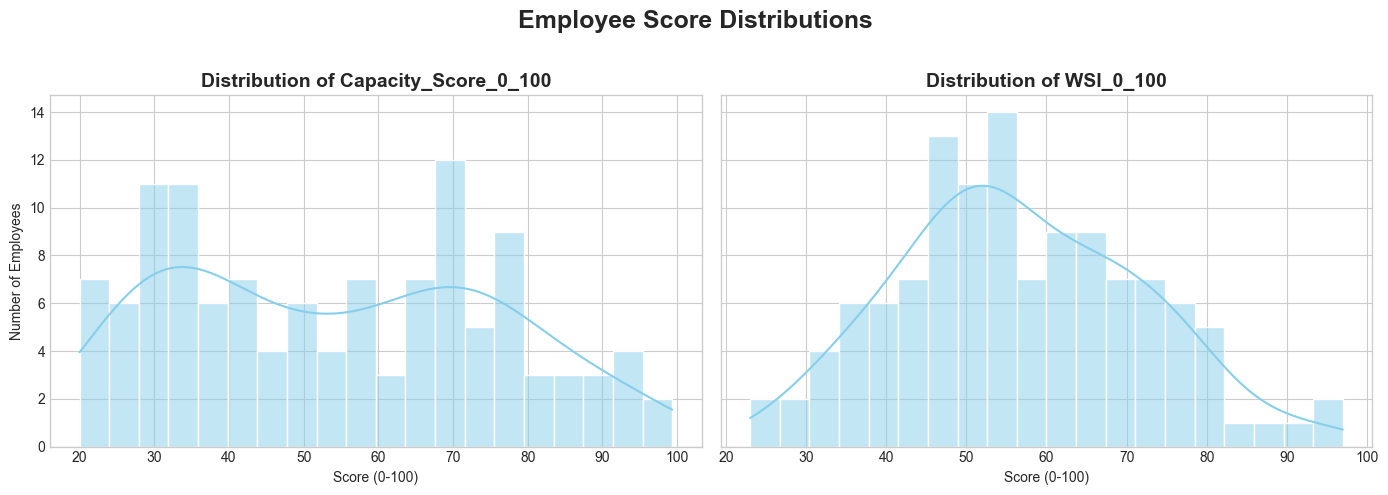


--- How do the teams compare on key WSI components over time? ---
Note: 'Capacity Deviation' now shows positive (above baseline) and negative (below baseline) performance.
✅ Plot saved to: team_metrics_over_time.png


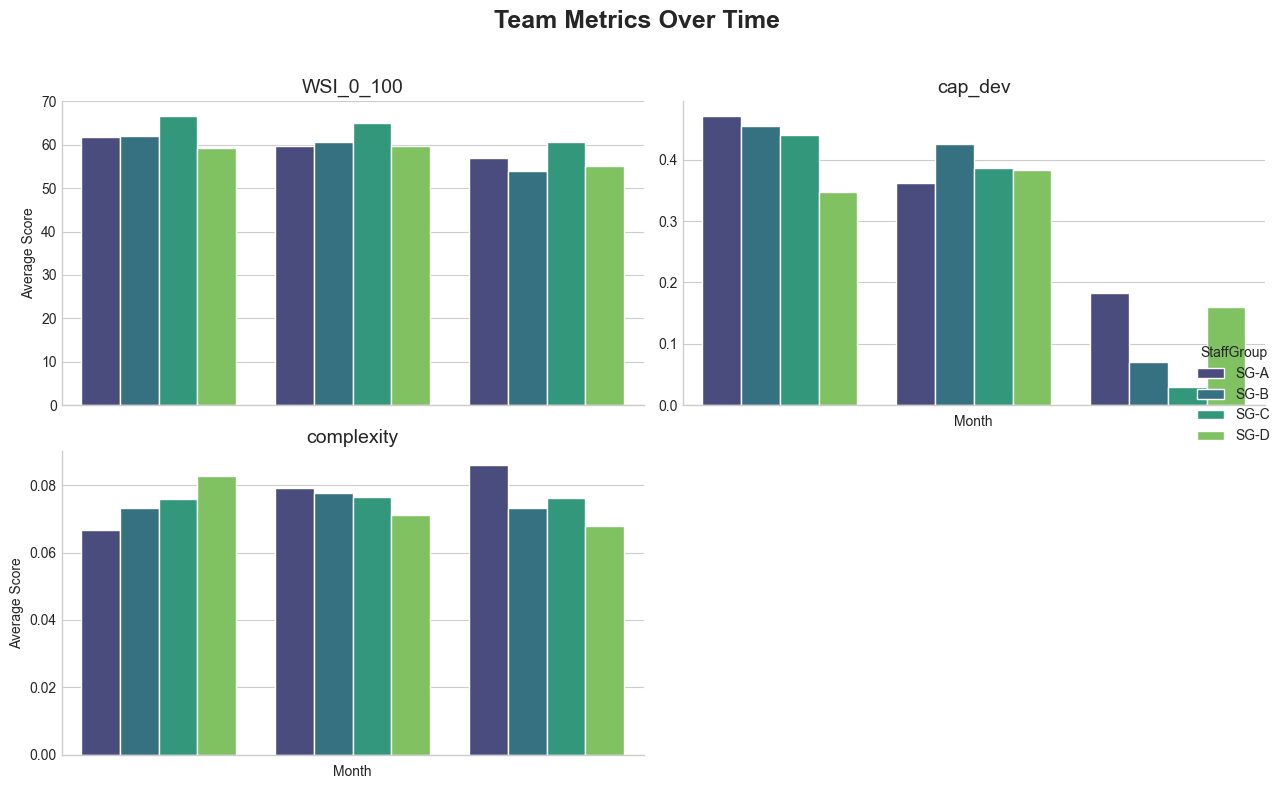

In [8]:
# --- Corrected Cell 5: ❓ Question 1: What are the Capacity Score & WSI? ---

# The Capacity Score (0-100) measures an employee's overall operational performance. A higher score is better.
# The Workload Stress Index (WSI) (0-100) measures workload pressure. A higher score indicates more stress.

# This dictionary will store the paths to all our saved plots.
saved_plots = {}

print("--- How are our employees distributed across these scores? (Latest Month) ---")
latest_month_df = alias_metrics[alias_metrics['_date_'] == alias_metrics['_date_'].max()]

# Define a path and save the plot
score_dist_path = "score_distributions.png"
plot_score_distributions(latest_month_df, ['Capacity_Score_0_100', 'WSI_0_100'], save_path=score_dist_path)
saved_plots["[INSERT SCORE DISTRIBUTION PLOT HERE]"] = score_dist_path


print("\n--- How do the teams compare on key WSI components over time? ---")
print("Note: 'Capacity Deviation' now shows positive (above baseline) and negative (below baseline) performance.")

# Define a path and save the plot
team_metrics_path = "team_metrics_over_time.png"
plot_team_metrics(team_metrics, ['WSI_0_100', 'cap_dev', 'complexity'], save_path=team_metrics_path)
saved_plots["[INSERT TEAM METRICS PLOT HERE]"] = team_metrics_path

### 🔬 Score Driver Analysis
This cell explains the "why" behind the Capacity Scores by analyzing the key drivers at two different levels:

1.  **Global Drivers:** The first plot identifies the most important features that influence the Capacity Score across the **entire organization**. This reveals which metrics are universally the most impactful for performance.
2.  **Local Drivers:** The second plot provides a "deep dive" into a single employee. The waterfall chart breaks down their specific score, showing exactly how each of their personal metrics contributed (positively or negatively) to their final result.

Both plots are saved as image files for reporting.

--- Global Drivers: What factors matter most across the organization? ---
✅ Plot saved to: feature_importance.png


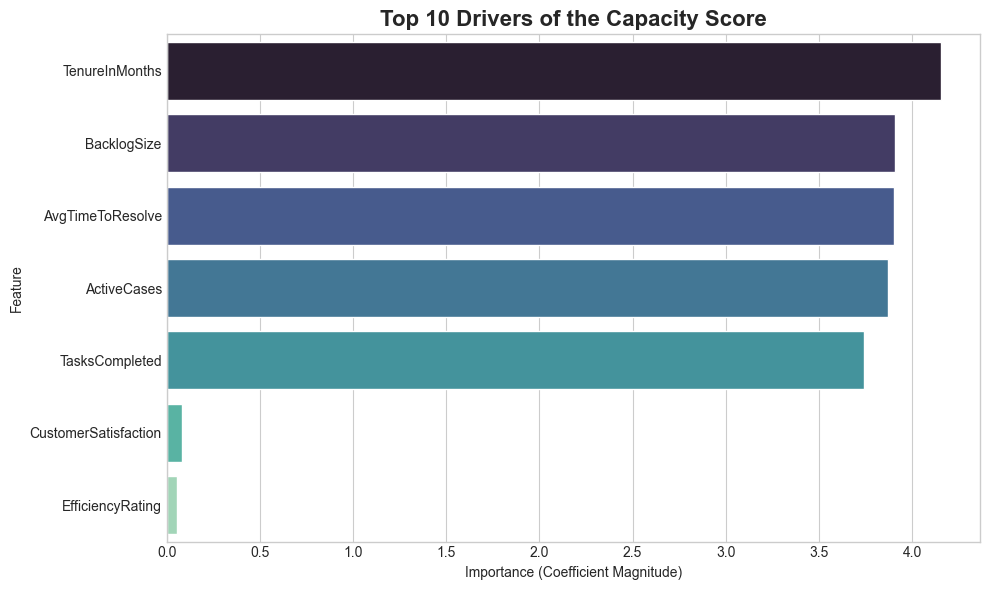


--- Local Drivers: Why did a specific employee get their score? ---
✅ Plot saved to: contributions_waterfall.png


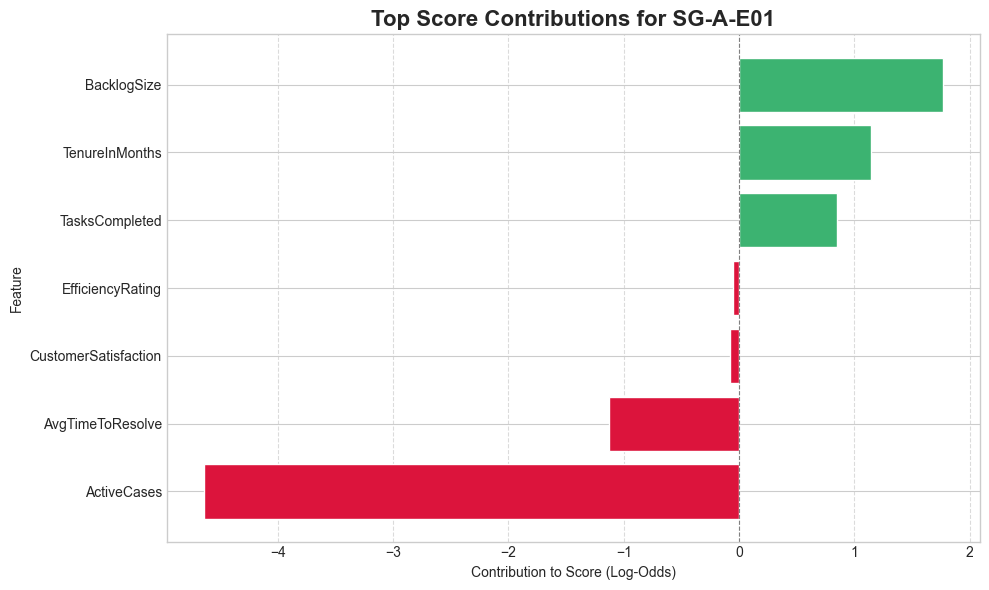

In [9]:

# In Cell [7]
print("--- Global Drivers: What factors matter most across the organization? ---")
feature_importance_path = "feature_importance.png" # Define path
plot_feature_importances(scorer, save_path=feature_importance_path) # Add save_path

print("\n--- Local Drivers: Why did a specific employee get their score? ---")
example_employee = df_prepped.iloc[0]
contributions = scorer.contributions(df_prepped, alias=example_employee[cols.alias], date=example_employee[cols.date])
contributions_path = "contributions_waterfall.png" # Define path
plot_contributions_waterfall(contributions, alias=example_employee[cols.alias], save_path=contributions_path) # Add save_path

### 🎲 What-If Scenario with Confidence Intervals
This cell simulates the impact of a hypothetical move—in this case, **transferring 5 employees from team SG-A to SG-C**.

Instead of running the simulation just once, it uses a **bootstrap** method. This technique re-runs the simulation many times on random samples of the data to measure the statistical certainty of the results. The output tables display:

1.  **Confidence Intervals (CI):** A 95% confidence range for each metric in the "Pre" and "Post" states, providing a robust estimate of the likely outcomes.
2.  **Delta (Δ) CI:** The confidence interval for the *net change* (Post - Pre), which quantifies the most probable impact of the move.

In [10]:
# 1) Point estimates from your existing call
# --- Corrected Cell 7: Consolidated "What-If" Scenario ---
print("This tool simulates moving employees between teams to see the projected impact.")

# 1. Define your hypothetical moves
moves = [
    {"from": "SG-A", "to": "SG-C", "n": 5}
]

# 3. Define the WSI calculation parameters
wsi_kwargs = dict(
    date_col="_date_",
    alias_col="alias",
    sg_col="StaffGroup",
    cap_col="Capacity_Score_0_100",
    cases_col="numCases",
    complexity_col="complexity",
    linearity_col="LinearityScore",
    sev_cols=("currentSev1", "currentSevA", "currentSevB"),
    weekend_col="IsClosedOnWeekend",
    x24_col="Is24X7OptedIn",
    baseline_window_months=12,
    persist_window_months=8,
    high_cap_thresh=75.0,
    w_workload=0.30,
    w_cap_dev=0.30,
    w_persist=0.15,
    w_complex=0.15,
    w_time=0.10,
    q_low=0.05,
    q_high=0.95,
    team_aggregate="median",
    distribution="gaussian",
    feature_range=(10, 100)
)

scores_baseline = scores[[cols.date, cols.alias, "Capacity_Score_0_100"]].dropna().copy()

print("m0:", _mstart(df_full["_date_"]).max())

point_estimates, ci_df, delta_ci_df = run_simulation_bootstrap(
    n_boot=5,
    df_full=df_full,
    scores_baseline=scores_baseline,
    month=df_full["_date_"].max().strftime("%Y-%m"),
    moves=moves,
    compute_wsi_fn=compute_capacity_centric_wsi,
    wsi_kwargs=wsi_kwargs,
    targets=("WSI_0_100","efficiency","days_to_close","backlog"),
    only_impacted=True,
    team_level_post=False,
    show_predict_samples=False,
    use_causal_sequence="learn",
    feature_scope=my_feature_columns,
    metrics_for_ci=["Capacity","numCases","WSI_0_100","efficiency","days_to_close","backlog"],
    base_seed=12345,
    # NEW:
    recompute_capacity_post=True,
    capacity_method="numcases_model",
    # If you already trained one:
    # numcases_model=my_pretrained_cap_from_cases_model
)

grid_pre, grid_post, combined, fig, mse_report, sanity_df = point_estimates

print("\n--- CI per Team × Scenario × Metric (95%) ---")
display(ci_df)

print("\n--- Δ (Post − Pre) CI per Team × Metric (95%) ---")
display(delta_ci_df)

This tool simulates moving employees between teams to see the projected impact.
m0: 2025-08-01 00:00:00
🧭 Learned DAG order: backlog → days_to_close → efficiency → WSI_0_100
  • backlog <= ['numCases', 'Capacity', 'StaffGroup']
  • days_to_close <= ['Capacity', 'numCases', 'backlog', 'StaffGroup']
  • efficiency <= ['Capacity', 'days_to_close', 'numCases', 'backlog', 'StaffGroup']
  • WSI_0_100 <= ['numCases', 'backlog', 'Capacity', 'days_to_close', 'efficiency', 'StaffGroup']

[INFO] Final feature sets per target:
       target                                                           features
    WSI_0_100 Capacity, numCases, StaffGroup, backlog, days_to_close, efficiency
      backlog                                     Capacity, numCases, StaffGroup
days_to_close                            Capacity, numCases, StaffGroup, backlog
   efficiency             Capacity, numCases, StaffGroup, backlog, days_to_close
Simulating moves for month=2025-08-01 ...
  • Move 5 aliases: SG-A → SG-C


,StaffGroup,Scenario,metric,mean,p2_5,p50,p97_5
0,SG-A,Post (pred),Capacity,50.91,35.17,48.81,68.84
1,SG-A,Post (pred),WSI_0_100,56.65,50.92,56.85,61.62
2,SG-A,Post (pred),backlog,24.73,21.87,24.90,27.55
3,SG-A,Post (pred),days_to_close,6.86,6.29,6.89,7.34
4,SG-A,Post (pred),efficiency,0.81,0.77,0.82,0.85
5,SG-A,Post (pred),numCases,41.94,30.82,42.85,55.52
6,SG-A,Pre,Capacity,58.81,48.99,53.55,72.18
7,SG-A,Pre,WSI_0_100,50.79,41.61,50.98,59.12
8,SG-A,Pre,backlog,19.60,16.10,18.00,25.50
9,SG-A,Pre,days_to_close,8.02,6.78,8.33,9.49



--- Δ (Post − Pre) CI per Team × Metric (95%) ---


,StaffGroup,metric,mean,p2_5,p50,p97_5
0,SG-A,Capacity,-7.90,-32.83,-17.38,19.85
1,SG-A,WSI_0_100,5.86,-2.73,2.32,17.68
2,SG-A,backlog,5.13,-0.18,3.90,11.30
3,SG-A,days_to_close,-1.16,-2.64,-1.03,0.46
4,SG-A,efficiency,0.04,-0.02,0.05,0.10
5,SG-A,numCases,1.04,-13.18,5.85,14.37
6,SG-C,Capacity,40.23,28.92,41.93,55.17
7,SG-C,WSI_0_100,4.08,-6.28,1.30,18.39
8,SG-C,backlog,2.47,-6.85,2.58,13.57
9,SG-C,days_to_close,3.69,2.12,3.51,5.56


### 📊 Visualizing the Simulation Outcome
This cell presents the results of the "what-if" simulation in three parts:

1.  **Sanity Check:** The first table displays the typical range of values for each metric. This serves as a baseline to judge whether the predicted outcomes are plausible or represent extreme changes.
2.  **Results Plot:** The main visualization shows a side-by-side, color-coded comparison of team metrics **before** and **after** the simulated employee move, with out-of-range values highlighted.
3.  **Detailed Data:** The final table shows the raw data that was used to generate the plot, provided for detailed inspection.

Finally, the main results plot is saved as a `.png` image file for easy use in reports or presentations.


--- Sanity Check: Typical Metric Ranges (based on pre-move data) ---


,p10,median,p95
metric,,,
Capacity,27.73,53.13,90.83
WSI_0_100,29.70,48.11,67.20
backlog,9.90,19.00,33.00
days_to_close,4.14,7.24,12.45
efficiency,0.68,0.80,0.91
numCases,30.00,42.00,68.00



--- Simulation Results: Comparing 'Before' vs. 'After' ---


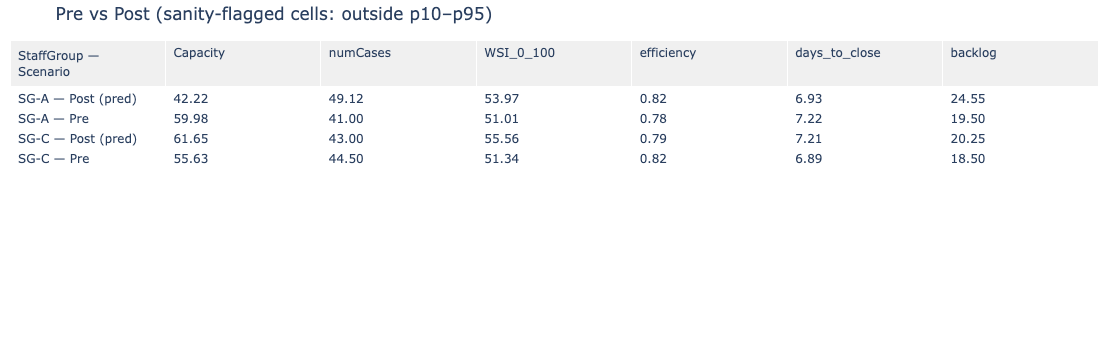


--- Detailed Dataframes ---


,StaffGroup,Capacity,numCases,WSI_0_100,efficiency,days_to_close,backlog,Scenario
0,SG-A,42.22,49.12,53.97,0.82,6.93,24.55,Post (pred)
1,SG-A,59.98,41.00,51.01,0.78,7.22,19.50,Pre
2,SG-C,61.65,43.00,55.56,0.79,7.21,20.25,Post (pred)
3,SG-C,55.62,44.50,51.34,0.82,6.89,18.50,Pre


✅ Simulation heatmap saved to: simulation_heatmap.png


In [11]:


# 6. Display the results
print("\n--- Sanity Check: Typical Metric Ranges (based on pre-move data) ---")
display(sanity_df)

print("\n--- Simulation Results: Comparing 'Before' vs. 'After' ---")
fig.show()

print("\n--- Detailed Dataframes ---")
display(combined)

# --- ADD THIS TO SAVE THE PLOT ---
# Define a path for the simulation heatmap
simulation_heatmap_path = "simulation_heatmap.png"

# Save the Plotly figure as a static image
# You may need to run: pip install -U kaleido
fig.write_image(simulation_heatmap_path)

print(f"✅ Simulation heatmap saved to: {simulation_heatmap_path}")

### 🎯 Curated Results View
This cell creates a customized and more focused view of the simulation results. It allows the user to **select a specific subset of key metrics** for the final report.

The code then filters the main data and sanity-check tables to match this selection, renames columns for better readability (e.g., `WSI_0_100` to `WSI`), and **generates a new, cleaner plot**. This tailored view makes it easier to present the most important takeaways from the simulation. The new plot is then displayed and saved.


--- Sanity Check: Typical Metric Ranges (p10–p95) ---


,p10,median,p95
metric,,,
Capacity,27.73,53.13,90.83
WSI,29.70,48.11,67.20
efficiency,0.68,0.80,0.91
DaysToClose,4.14,7.24,12.45
backlog,9.90,19.00,33.00



--- Simulation Results: Comparing 'Before' vs. 'After' (selected metrics) ---


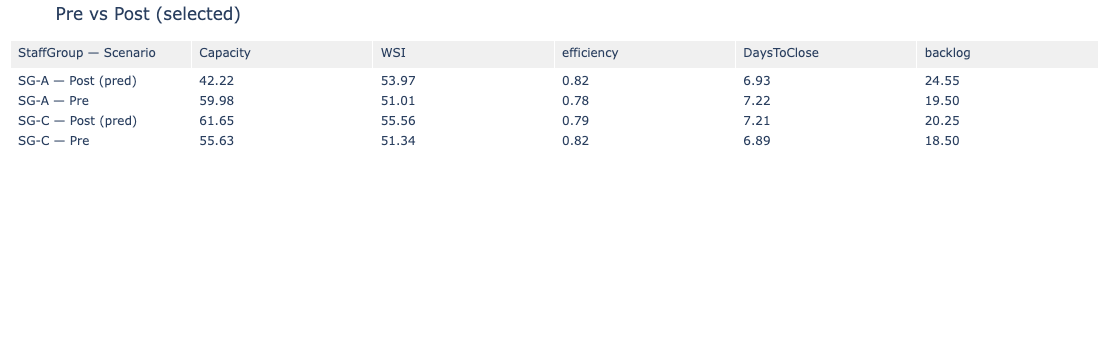


--- Detailed Dataframe (selected metrics) ---


,StaffGroup,Scenario,Capacity,WSI,efficiency,DaysToClose,backlog
0,SG-A,Post (pred),42.22,53.97,0.82,6.93,24.55
1,SG-A,Pre,59.98,51.01,0.78,7.22,19.50
2,SG-C,Post (pred),61.65,55.56,0.79,7.21,20.25
3,SG-C,Pre,55.62,51.34,0.82,6.89,18.50


✅ Simulation heatmap (selected metrics) saved to: simulation_heatmap_selected.png


In [12]:
# --- PICK WHAT YOU WANT TO SHOW IN THE TABLE/PLOT ---
from capacity_pipeline import plot_color_grid_with_sanity_range
metrics_to_show = [
    "Capacity", "WSI_0_100", "efficiency", "days_to_close", "backlog"
]
# ^ keep/remove/reorder as you like; only columns present in `combined` will be used.

# 1) Build a trimmed view of the combined table
wanted_cols = ["StaffGroup", "Scenario"] + [m for m in metrics_to_show if m in combined.columns]
combined_view = combined[wanted_cols].copy()

# 2) Align sanity_df to the selected metrics (only metrics with p10/p95)
metrics_in_sanity = [m for m in metrics_to_show if m in sanity_df.index]
sanity_use = sanity_df.loc[metrics_in_sanity].copy()

rename_map = {"WSI_0_100": "WSI", "days_to_close": "DaysToClose"}
combined_view = combined_view.rename(columns=rename_map)
sanity_use = sanity_use.rename(index=rename_map)
fig_sel = plot_color_grid_with_sanity_range(
    combined_table=combined_view,
    sanity_df=sanity_use,
    metrics=[rename_map.get(m, m) for m in metrics_in_sanity],
    low_col="p10", high_col="p95",
    title="Pre vs Post (selected)"
)

# 4) Display
print("\n--- Sanity Check: Typical Metric Ranges (p10–p95) ---")
display(sanity_use)

print("\n--- Simulation Results: Comparing 'Before' vs. 'After' (selected metrics) ---")
fig_sel.show()

print("\n--- Detailed Dataframe (selected metrics) ---")
display(combined_view)

# 5) Save the selected plot (optional)
simulation_heatmap_path = "simulation_heatmap_selected.png"
fig_sel.write_image(simulation_heatmap_path)
print(f"✅ Simulation heatmap (selected metrics) saved to: {simulation_heatmap_path}")

### 🚀 Simulating Performance Improvement (Bucket Uplift)
This cell models the potential impact of upskilling employees. Instead of moving people between teams, it simulates shifting a percentage of employees from lower **performance buckets** (defined by their Capacity Score) to higher ones.

The core logic assumes that when an employee "moves" to a higher bucket, their workload capacity (`numCases`) rises to match the median of that new, higher-performing group. The analysis produces:

1.  A **summary table** detailing the change in headcount per bucket and calculating the total "uplift" in cases handled due to the improvements.
2.  A **distribution plot** that visualizes how the overall workload distribution shifts, providing a clear picture of the simulated productivity gain.

Running with flexible move plan:
- Moving 1 employees from '0-25' to '50-75'
- Moving 4 employees from '25-50' to '75-100'
- Moving 5 employees from '50-75' to '75-100'
- Moving 1 employees from '0-25' to '75-100'

--- Bucket Uplift Summary ---


,bucket,aliases_before,moved_out,moved_in,aliases_after,nc_median,pct_before,pct_after,original_cases_handled,new_cases_bucket,net_incremental_cases
0,0-25,8,2,0,6,62.00,6.67,5.00,0.00,0.00,0.00
1,25-50,48,4,0,44,50.00,40.00,36.67,0.00,0.00,0.00
2,50-75,38,5,1,34,41.00,31.67,28.33,62.00,41.00,-21.00
3,75-100,26,0,10,36,33.50,21.67,30.00,467.00,335.00,-132.00
4,TOTAL,120,11,11,120,NaN,100.00,100.00,529.00,376.00,-153.00


✅ Volume uplift plot saved to: total_volume_uplift_distribution.png


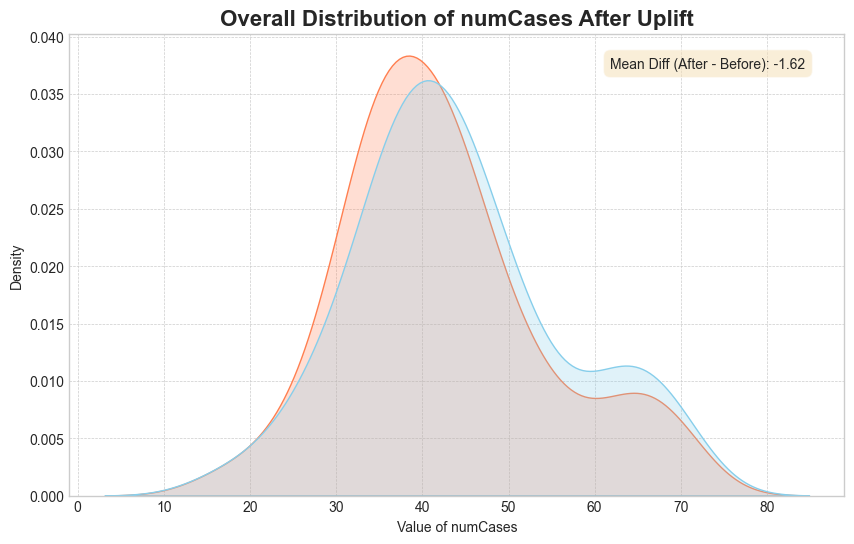


--- Sanity Check Calculation ---
Total 'numCases' Before Simulation: 5,282.00
Total 'numCases' After Simulation:  5,087.00
Total Simulated Uplift:             -195.00


In [13]:
import numpy as np
import pandas as pd

def run_bucket_uplift_analysis(
    alias_metrics_df: pd.DataFrame,
    cap_edges: list[float] = [0, 25, 50, 75, 100],
    moves: list[dict] | None = None
):
    """
    Performs a flexible uplift analysis, returning both an aggregate summary
    and the detailed 'before' and 'after' dataframes for plotting.

    NEW / CHANGED:
    - Shows distinct alias counts by bucket (before & after).
    - Adds moved_out and aliases_after (aliases_before - moved_out + moved_in).
    - Adds pct_after (share after moves).
    - TOTAL row includes sums where meaningful.
    """
    if moves is None:
        moves = []

    df = alias_metrics_df.copy()
    cap_labels = [f"{int(cap_edges[i])}-{int(cap_edges[i+1])}" for i in range(len(cap_edges)-1)]

    # 1) Assign employees to initial capacity buckets
    df["bucket"] = pd.cut(
        df["Capacity_Score_0_100"], bins=cap_edges,
        labels=cap_labels, include_lowest=True
    )

    # 2) 'Before' and 'After' frames (after will be mutated by moves)
    pre_volume_df  = df.copy()
    post_volume_df = df.copy()

    # 3) Initial stats (distinct aliases per bucket + median numCases)
    stats = (
        df.groupby("bucket", observed=False)
          .agg(aliases=("alias", "nunique"), nc_median=("numCases", "median"))
          .reindex(cap_labels)
          .reset_index()
    ).fillna({"aliases": 0, "nc_median": np.nan})

    # Convenience lookups
    aliases_by_bucket = {
        b: set(df.loc[df["bucket"] == b, "alias"].unique()) for b in cap_labels
    }

    # 4) Apply move plan (only numCases is adjusted; bucket membership stays as "capacity buckets")
    #    If your design later changes capacity/ buckets after moves, you can recompute bucket here.
    print("Running with flexible move plan:")
    for move in moves:
        source_idx, dest_idx, pct = move.get("from"), move.get("to"), move.get("pct")
        if any(v is None for v in [source_idx, dest_idx, pct]):
            continue
        if not (0 <= source_idx < len(stats) and 0 <= dest_idx < len(stats)):
            continue

        src_bucket = cap_labels[source_idx]
        dst_bucket = cap_labels[dest_idx]

        src_aliases = np.array(list(aliases_by_bucket.get(src_bucket, set())))
        n_to_move   = int(np.floor(len(src_aliases) * pct))

        if n_to_move > 0 and len(src_aliases) > 0:
            print(f"- Moving {n_to_move} employees from '{src_bucket}' to '{dst_bucket}'")
            moved_aliases = np.random.choice(src_aliases, size=n_to_move, replace=False)

            # Update numCases in post-simulation dataframe to the destination median
            target_median = stats.loc[dest_idx, "nc_median"]
            if pd.notna(target_median):
                post_volume_df.loc[post_volume_df["alias"].isin(moved_aliases), "numCases"] = target_median

            # Track moved_out / moved_in sets to compute aliases_after
            # (Note: we're NOT changing capacity buckets here—only showing headcount effects of moves)
            move.setdefault("_moved_from_set", set())
            move.setdefault("_moved_to_set", set())
            move["_moved_from_set"].update(set(moved_aliases))
            move["_moved_to_set"].update(set(moved_aliases))

    # 5) Aggregate move counts by source/dest bucket
    moved_out_counts = {b: 0 for b in cap_labels}
    moved_in_counts  = {b: 0 for b in cap_labels}
    for move in moves:
        src_idx, dst_idx = move.get("from"), move.get("to")
        if isinstance(src_idx, int) and 0 <= src_idx < len(cap_labels):
            moved_out_counts[cap_labels[src_idx]] += len(move.get("_moved_from_set", set()))
        if isinstance(dst_idx, int) and 0 <= dst_idx < len(cap_labels):
            moved_in_counts[cap_labels[dst_idx]]  += len(move.get("_moved_to_set", set()))

    # 6) Build summary (before/after alias counts + case uplift math as you had)
    summary_stats = stats.copy()
    summary_stats.rename(columns={"aliases": "aliases_before"}, inplace=True)
    summary_stats["moved_out"] = summary_stats["bucket"].map(moved_out_counts).fillna(0).astype(int)
    summary_stats["moved_in"]  = summary_stats["bucket"].map(moved_in_counts).fillna(0).astype(int)
    summary_stats["aliases_after"] = (
        summary_stats["aliases_before"] - summary_stats["moved_out"] + summary_stats["moved_in"]
    ).astype(int)

    # Keep your cases delta math (based on plan)
    summary_stats["new_cases_bucket"]        = 0.0
    summary_stats["original_cases_handled"]  = 0.0

    for move in moves:
        source_idx, dest_idx, pct = move.get("from"), move.get("to"), move.get("pct")
        if any(v is None for v in [source_idx, dest_idx, pct]):
            continue
        if not (0 <= source_idx < len(summary_stats) and 0 <= dest_idx < len(summary_stats)):
            continue

        # employees moving (based on BEFORE)
        num_moving = int(np.floor(summary_stats.loc[source_idx, "aliases_before"] * pct))
        if num_moving > 0:
            src_med = summary_stats.loc[source_idx, "nc_median"]
            dst_med = summary_stats.loc[dest_idx, "nc_median"]
            if pd.notna(src_med):
                summary_stats.loc[dest_idx, "original_cases_handled"] += num_moving * float(src_med)
            if pd.notna(dst_med):
                summary_stats.loc[dest_idx, "new_cases_bucket"] += num_moving * float(dst_med)

    summary_stats["net_incremental_cases"] = (
        summary_stats["new_cases_bucket"] - summary_stats["original_cases_handled"]
    )

    # Percent shares (before & after)
    total_before = max(1, summary_stats["aliases_before"].sum())
    total_after  = max(1, summary_stats["aliases_after"].sum())
    summary_stats["pct_before"] = (summary_stats["aliases_before"] / total_before * 100).round(2)
    summary_stats["pct_after"]  = (summary_stats["aliases_after"]  / total_after  * 100).round(2)

    # 7) TOTAL row
    total_row = pd.DataFrame([{
        "bucket": "TOTAL",
        "aliases_before": int(summary_stats["aliases_before"].sum()),
        "moved_out": int(summary_stats["moved_out"].sum()),
        "moved_in": int(summary_stats["moved_in"].sum()),
        "aliases_after": int(summary_stats["aliases_after"].sum()),
        "nc_median": np.nan,  # not meaningful to sum medians
        "pct_before": 100.0,
        "pct_after": 100.0,
        "original_cases_handled": float(summary_stats["original_cases_handled"].sum()),
        "new_cases_bucket": float(summary_stats["new_cases_bucket"].sum()),
        "net_incremental_cases": float(summary_stats["net_incremental_cases"].sum()),
    }])

    # 8) Final display columns (now includes distinct alias counts and TOTAL)
    display_cols = [
        "bucket",
        "aliases_before", "moved_out", "moved_in", "aliases_after",
        "nc_median",
        "pct_before", "pct_after",
        "original_cases_handled", "new_cases_bucket", "net_incremental_cases"
    ]
    summary_df = pd.concat([summary_stats, total_row], ignore_index=True)[display_cols]

    return summary_df, pre_volume_df, post_volume_df
    

# --- Run the Analysis ---
uplift_input_df = df_scored[df_scored['_date_'] == df_scored['_date_'].max()].merge(
    alias_metrics[['_date_', 'alias', 'WSI_0_100']], on=['_date_', 'alias']
)

# Define your flexible moves
flexible_moves = [
    {"from": 0, "to": 2, "pct": 0.15},
    {"from": 1, "to": 3, "pct": 0.10},
    {"from": 2, "to": 3, "pct": 0.15},
    {"from": 0, "to": 3, "pct": 0.15}
]

# A single function call now provides all three results
bucket_uplift_summary, pre_volume_df, post_volume_df = run_bucket_uplift_analysis(
    uplift_input_df,
    moves=flexible_moves
)

# --- Display the Summary Table ---
print("\n--- Bucket Uplift Summary ---")
display(bucket_uplift_summary)

# --- Plot the Distribution ---
volume_dist_path = "total_volume_uplift_distribution.png"
plot_volume_uplift_distributions(
    pre_df=pre_volume_df,
    post_df=post_volume_df,
    metric='numCases',
    save_path=volume_dist_path
)
saved_plots["[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]"] = volume_dist_path

# --- Run the Sanity Check ---
sum_before = pre_volume_df['numCases'].sum()
sum_after = post_volume_df['numCases'].sum()
simulated_uplift = sum_after - post_volume_df['numCases'][post_volume_df['alias'].isin(pre_volume_df['alias']) == False].sum()


print(f"\n--- Sanity Check Calculation ---")
print(f"Total 'numCases' Before Simulation: {sum_before:,.2f}")
print(f"Total 'numCases' After Simulation:  {sum_after:,.2f}")
print(f"Total Simulated Uplift:             {sum_after - sum_before:,.2f}")



### 📋 2x2 Performance Quadrant Analysis
This cell segments the workforce into four distinct performance categories using a classic 2x2 grid. It uses the median **Capacity Score** (performance) and the median **WSI** (strain) as the dividing lines.

The four resulting quadrants represent key employee personas:
* **High Capacity / Low WSI:** Top performers who are highly productive and not over-stressed.
* **High Capacity / High WSI:** Productive employees who are at risk of burnout.
* **Low Capacity / Low WSI:** Employees who may be underutilized or have room for development.
* **Low Capacity / High WSI:** Individuals who are struggling and may require support.

The analysis is run first for the entire organization and then for a specific subset of teams, with the resulting plots saved as images.

This analysis segments employees into four performance categories based on their Capacity and WSI scores.

--- Quadrant Analysis for ALL Groups ---
✅ Plot saved to: quadrant_all_groups.png


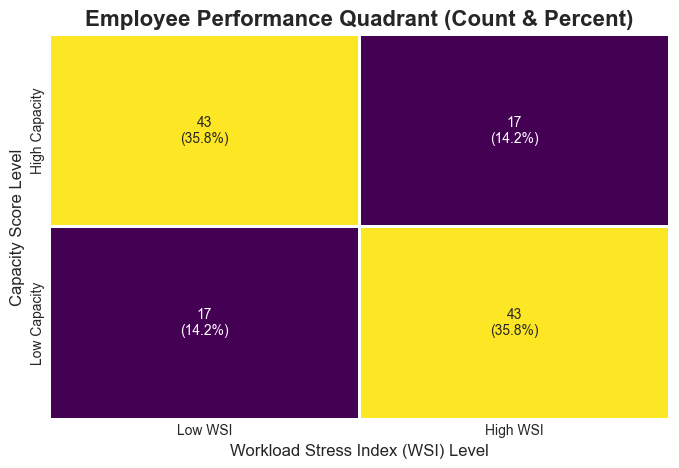

WSI Level,Low WSI,High WSI
Capacity Level,,
High Capacity,43\n(35.8%),17\n(14.2%)
Low Capacity,17\n(14.2%),43\n(35.8%)



--- Quadrant Analysis for SG-A and SG-C Only ---
✅ Plot saved to: quadrant_filtered_groups.png


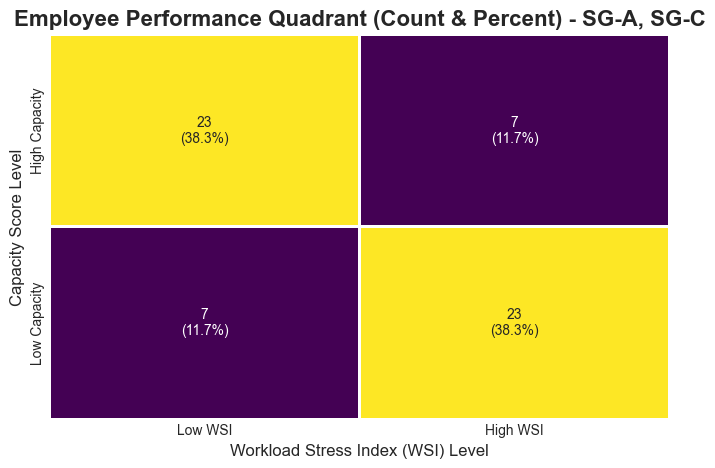

WSI Level,Low WSI,High WSI
Capacity Level,,
High Capacity,23\n(38.3%),7\n(11.7%)
Low Capacity,7\n(11.7%),23\n(38.3%)


In [14]:
# --- 📊 2x2 Performance Quadrant Analysis (Now saves the plots) ---
print("This analysis segments employees into four performance categories based on their Capacity and WSI scores.")

def create_performance_quadrant(alias_metrics_df, group_filter=None, save_path: Optional[str] = None):
    df = alias_metrics_df.copy()
    if group_filter:
        df = df[df['StaffGroup'].isin(group_filter)]

    if df.empty:
        print("No data for the selected filter.")
        return pd.DataFrame(), None # Return None for the path

    cap_median = df['Capacity_Score_0_100'].median()
    wsi_median = df['WSI_0_100'].median()

    # Create separate columns for the 2x2 grid
    df['Capacity Level'] = np.where(df['Capacity_Score_0_100'] >= cap_median, 'High Capacity', 'Low Capacity')
    df['WSI Level'] = np.where(df['WSI_0_100'] >= wsi_median, 'High WSI', 'Low WSI')

    # Create the 2x2 grid of counts and percentages
    count_table = pd.crosstab(df['Capacity Level'], df['WSI Level'])
    if 'Low WSI' in count_table.columns:
        count_table = count_table[['Low WSI', 'High WSI']]
    percent_table = (count_table / len(df) * 100).round(1)
    annot_table = count_table.astype(str) + "\n(" + percent_table.astype(str) + "%)"

    # Visualization: Heatmap of the 2x2 Grid
    plt.figure(figsize=(8, 5))
    sns.heatmap(
        count_table,
        annot=annot_table,
        fmt='s',
        cmap="viridis",
        cbar=False,
        linewidths=2,
        linecolor='white'
    )
    title = 'Employee Performance Quadrant (Count & Percent)'
    if group_filter:
        title += f" - {', '.join(group_filter)}"
    plt.title(title, fontsize=16, weight='bold')
    plt.ylabel('Capacity Score Level', fontsize=12)
    plt.xlabel('Workload Stress Index (WSI) Level', fontsize=12)
    
    # --- ADDED SAVE LOGIC ---
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
        print(f"✅ Plot saved to: {save_path}")

    plt.show()

    # Return the formatted table and the path to the saved image
    return annot_table, save_path

# --- Run the Analysis for ALL Groups ---
print("\n--- Quadrant Analysis for ALL Groups ---")
quadrant_all_path = "quadrant_all_groups.png"
wsi_capacity_quadrant_all, path1 = create_performance_quadrant(latest_month_df, save_path=quadrant_all_path)
if path1:
    saved_plots["[INSERT QUADRANT PLOT ALL GROUPS HERE]"] = path1
display(wsi_capacity_quadrant_all)


# --- Run for a specific subset of groups ---
print("\n--- Quadrant Analysis for SG-A and SG-C Only ---")
quadrant_filtered_path = "quadrant_filtered_groups.png"
wsi_capacity_quadrant_filtered, path2 = create_performance_quadrant(latest_month_df, group_filter=['SG-A', 'SG-C'], save_path=quadrant_filtered_path)
if path2:
    saved_plots["[INSERT QUADRANT PLOT FILTERED HERE]"] = path2
display(wsi_capacity_quadrant_filtered)




In [15]:
# # --- ❓ Question 4: What is the optimal headcount distribution? ---

# print("This tool runs an optimization algorithm to find a set of employee moves")
# print("that best achieves our defined business goals (e.g., reducing WSI and backlog).")

# # --- 1) Define Business Goals for Optimization ---
# opt_cfg = OptimizeConfig(
#     budget_moves=15,
#     objective_weights={
#         WSI_COL: -1.0,
#         EFFICIENCY_COL: +0.6,
#         DTC_COL: -0.6,
#         "backlog": -0.8,   # canonical name expected by the grids
#         "numCases": +0.25  # canonical name expected by the grids
#     },
#     random_state=42
# )

# # --- 2) Run the Full Optimizer Pipeline ---
# plan_output = run_optimizer_pipeline(
#     df_full=df_full,
#     scores_baseline=scores,
#     opt_cfg=opt_cfg,
#     cols=cols,
#     compute_wsi_fn=compute_capacity_centric_wsi,
#     wsi_kwargs=wsi_kwargs,
#     targets=modeler_targets,
#     only_impacted=False  # important so the first step evaluates all teams
# )

# # --- 3) Display the Results ---
# print("\n--- Recommended Reassignment Plan (Net Moves) ---")

# plan_list = plan_output.get("plan", [])
# if not plan_list:
#     print("No improving moves found within the budget and objective; the optimizer returned an empty plan.")
# else:
#     plan_df = pd.DataFrame(plan_list)

#     # Normalize column names for the plotting helper
#     if {"from", "to"}.issubset(plan_df.columns):
#         plan_for_plot = plan_df.rename(columns={"from": "from_group", "to": "to_group"})
#     elif {"from_group", "to_group"}.issubset(plan_df.columns):
#         plan_for_plot = plan_df.copy()
#     else:
#         display(plan_df.head())
#         raise ValueError("Expected ['from','to','n'] or ['from_group','to_group','n'].")

#     # Summary table
#     plan_summary = (
#         plan_for_plot
#         .groupby(["from_group", "to_group"])
#         .size()
#         .reset_index(name="count")
#         .sort_values("count", ascending=False)
#     )
#     display(plan_summary)

#     # Plot and stash
#     optimizer_plan_path = "optimizer_plan.png"
#     plot_optimization_plan(plan_for_plot.to_dict("records"), save_path=optimizer_plan_path)
#     if "saved_plots" not in globals():
#         saved_plots = {}
#     saved_plots["[INSERT OPTIMIZER PLAN PLOT HERE]"] = optimizer_plan_path

# print("\n--- Projected Metrics: Initial vs. Optimized State ---")
# comparison = plan_output["initial_metrics"].merge(
#     plan_output["expected_metrics"],
#     on="StaffGroup",
#     suffixes=("_Initial", "_Optimized")
# )
# display(comparison)

### 🤖 Automated Report Generation
This cell is a utility that **automatically generates a comprehensive prompt** for an AI (Large Language Model) to write a full business analysis report.

It contains functions that take all the previously created data tables and analysis results (like the simulation outcomes, quadrant analysis, etc.) and formats them into a single, structured prompt. It can generate two types of prompts:

1.  A text-only version with data tables.
2.  A version with `[PLACEHOLDER]` tags for easily inserting the saved plots and charts.

The final output of this cell is the complete, formatted prompt, ready to be used by an LLM to create the final executive summary.

In [16]:
# """
# Business Analysis Prompt Generation Utility

# This script provides functions to dynamically generate detailed prompts for a Large
# Language Model (LLM) to create executive-level business analysis reports. It is
# designed to be run within a data analysis environment (like a Jupyter notebook)
# where the necessary data objects (pandas DataFrames, scorer objects, configs)
# have already been created and populated.

# The main functions are:
# - generate_llm_text_prompt: Creates a text-only prompt for the LLM.
# - generate_llm_placeholder_prompt: Creates a prompt that includes placeholder tags
#   for inserting plots/visualizations into the final report.
# """
# import pandas as pd

# def _md(obj, *, index=False, default="(no data)"):
#     """
#     Robustly convert obj to markdown text.
#     Handles DataFrame, Series, dict, list of dicts/tuples, strings, None.
#     """
#     try:
#         if obj is None:
#             return default
#         if isinstance(obj, pd.DataFrame):
#             if obj.empty:
#                 return default
#             return obj.to_markdown(index=index)
#         if isinstance(obj, pd.Series):
#             if obj.empty:
#                 return default
#             return obj.to_frame(name=obj.name or "value").to_markdown(index=index)
#         if isinstance(obj, dict):
#             if not obj:
#                 return default
#             # Handle specific nested DataFrame structures if necessary
#             if all(isinstance(v, (pd.DataFrame, pd.Series)) for v in obj.values()):
#                  # A more complex handler could be added here if needed
#                  return "\n".join([f"**{k}**:\n{_md(v)}" for k, v in obj.items()])
#             df = pd.DataFrame(list(obj.items()), columns=["key", "value"])
#             return df.to_markdown(index=False)
#         if isinstance(obj, (list, tuple)):
#             if not obj:
#                 return default
#             # list of dicts → DataFrame
#             if all(isinstance(x, dict) for x in obj):
#                 df = pd.DataFrame(obj)
#                 if df.empty:
#                     return default
#                 return df.to_markdown(index=index)
#             # list/tuple of tuples → DataFrame
#             if all(isinstance(x, (list, tuple)) for x in obj):
#                 df = pd.DataFrame(obj)
#                 if df.empty:
#                     return default
#                 return df.to_markdown(index=index)
#             # otherwise dump as Series
#             return pd.Series(obj).to_frame("value").to_markdown(index=index)
#         # string / other
#         s = str(obj).strip()
#         return s if s else default
#     except Exception as e:
#         return f"(render error: {e})"

# def _feature_importances_md(scorer_obj):
#     """
#     Try to render feature importances; return a friendly note if unavailable.
#     """
#     try:
#         fi = scorer_obj.feature_importances()
#         if isinstance(fi, pd.DataFrame) and not fi.empty:
#             return fi.to_markdown(index=False)
#         return "(feature importances not available)"
#     except Exception:
#         return "(feature importances not available for this scoring method)"

# def _weights_md(weights_like, first="Component", second="Weight"):
#     if hasattr(weights_like, "items"):
#         df = pd.DataFrame(list(weights_like.items()), columns=[first, second])
#         return _md(df, index=False)
#     return _md(weights_like)

# def generate_llm_text_prompt(
#     team_metrics_df,
#     scorer_obj,
#     simulation_df,        # 'combined' dataframe (pre/post stacked)
#     sanity_df,
#     mse_report_df,
#     example_capacity_contributions_df,
#     example_wsi_contributions_df,
#     opt_plan_obj,         # Can be None if optimizer is not run
#     bucket_uplift_df,
#     quadrant_df,
#     filtered_quadrant_df,
#     wsi_config,
#     opt_config,
#     post_volume_df
# ):
#     """
#     Compiles a comprehensive, text-only prompt using robust markdown conversion.
#     """

#     # --- Robust markdown conversions ---
#     team_metrics_md     = _md(team_metrics_df, index=False)
#     feature_importance_md= _feature_importances_md(scorer_obj)
#     simulation_md       = _md(simulation_df, index=False)
#     bucket_uplift_md    = _md(bucket_uplift_df, index=False)
#     quadrant_md         = _md(quadrant_df, index=False)
#     filtered_quadrant_md = _md(filtered_quadrant_df, index=False)
#     wsi_weights_md      = _weights_md(getattr(wsi_config, "weights", {}), first="Component", second="Weight")
#     try:
#         post_volume_md = _md(post_volume_df[["numCases"]].describe())
#     except Exception:
#         post_volume_md = _md(post_volume_df)

#     sanity_md           = _md(sanity_df, index=False)
#     mse_md              = _md(mse_report_df, index=False)
#     example_capacity_contributions_md = _md(example_capacity_contributions_df, index=False)
#     example_wsi_contributions_md = _md(example_wsi_contributions_df, index=False)

#     # --- Conditionally build the optimizer section ---
#     optimizer_section = ""
#     quadrant_section_number = 5
#     if opt_plan_obj:
#         opt_plan_md         = _md(opt_plan_obj.get("plan"), index=False)
#         opt_expected_md     = _md(opt_plan_obj.get("expected_metrics"), index=False)
#         opt_weights_md      = _weights_md(getattr(opt_config, "objective_weights", {}), first="Metric", second="Weight")
#         optimizer_section = f"""
# ### 4. Optimal Headcount Reassignment
# **Your Task:** Explain how the Optimizer works, present the recommended plan, and summarize expected improvements.
# **Data:**
# *Optimizer Business Goals (Objective Weights):*
# {opt_weights_md}
# *Recommended Moves:*
# {opt_plan_md}
# *Expected State Metrics:*
# {opt_expected_md}
# """
#     else:
#         quadrant_section_number = 4

#     prompt = f"""
# You are an expert business analyst and communicator. Your task is to generate a detailed business analysis report for executive stakeholders who are not data scientists. For each section, you must first **explain the methodology** in simple, non-technical terms, and then **summarize the key findings** from the data provided for that section.

# --- DATA AND INSTRUCTIONS ---

# ### 1. The Capacity Score & WSI
# **Your Task:** Explain how the Capacity Score and WSI are calculated, using the employee data below as a concrete, step-by-step example.
# 1.  **For the Capacity Score:** Explain that the final `Capacity_Score_0_100` is the result of a model's base prediction being adjusted by each feature's `contribution`. Show this by referencing specific features and their contribution values from the "Capacity Score Contributions" table.
# 2.  **For the WSI:** Explain that the WSI is a weighted average. Using the "WSI Contributions" table, show how each `component_value` is multiplied by its `weight` to get the `weighted_contribution`. Explain that the final `WSI_0_100` score is derived from these weighted values.
# 3.  **Finally:** Discuss the key global drivers from the "Global Feature Importance" table and summarize the overall team performance.

# **Data:**
# *Global Feature Importance:*
# {feature_importance_md}
# *Local Contributions for One Employee (Example for Score Calculation):*
# **Capacity Score Contributions:**
# {example_capacity_contributions_md}

# **WSI Contributions:**
# {example_wsi_contributions_md}
# *Team Performance Metrics:*
# {team_metrics_md}
# *WSI Component Weights:*
# {wsi_weights_md}

# ### 2. "What-If" Headcount Simulation
# **Your Task:** Explain that the simulation uses predictive models to estimate outcomes. Summarize the projected impact of the specific moves. Also, comment on the model's accuracy using the MSE report and provide context using the sanity check data.
# **Data:**
# *Simulation Results (Pre vs. Post):*
# {simulation_md}
# *Model Performance (Mean Squared Error - lower is better):*
# {mse_md}
# *Sanity Check (Typical Metric Ranges):*
# {sanity_md}

# ### 3. Bucket Uplift & Overall Volume Impact
# **Your Task:** Explain the "Bucket Uplift" analysis and state the total estimated incremental cases. Then, explain the "Overall Volume Impact" simulation, summarizing the change in the mean `numCases`.
# **Data:**
# *Bucket Uplift Summary:*
# {bucket_uplift_md}
# *Overall Volume Impact (Post-Simulation 'numCases' stats):*
# {post_volume_md}
# {optimizer_section}
# ### {quadrant_section_number}. Performance Quadrant Analysis
# **Your Task:** Explain the four quadrants and summarize the employee distribution for both the overall organization and the specific filtered groups (SG-A and SG-C).
# **Data:**
# *Overall 2x2 Performance Quadrant Grid:*
# {quadrant_md}
# *Filtered (SG-A & SG-C) 2x2 Performance Quadrant Grid:*
# {filtered_quadrant_md}

# --- END OF DATA ---

# Now, generate the full, detailed business analysis report based on these instructions and data.
# """
#     return prompt


# def generate_llm_placeholder_prompt(
#     team_metrics_df,
#     scorer_obj,
#     simulation_df,        # 'combined' dataframe
#     sanity_df,
#     mse_report_df,
#     example_capacity_contributions_df,
#     example_wsi_contributions_df,
#     opt_plan_obj,         # Can be None if optimizer is not run
#     bucket_uplift_df,
#     quadrant_df,
#     filtered_quadrant_df,
#     wsi_config,
#     opt_config,
#     post_volume_df
# ):
#     """
#     Same as text prompt but with explicit placeholder tags for plots.
#     """
#     team_metrics_md     = _md(team_metrics_df, index=False)
#     feature_importance_md= _feature_importances_md(scorer_obj)
#     simulation_md       = _md(simulation_df, index=False)
#     bucket_uplift_md    = _md(bucket_uplift_df, index=False)
#     quadrant_md         = _md(quadrant_df, index=False)
#     filtered_quadrant_md = _md(filtered_quadrant_df, index=False)
#     wsi_weights_md      = _weights_md(getattr(wsi_config, "weights", {}), first="Component", second="Weight")
#     try:
#         post_volume_md = _md(post_volume_df[["numCases"]].describe())
#     except Exception:
#         post_volume_md = _md(post_volume_df)

#     sanity_md           = _md(sanity_df, index=False)
#     mse_md              = _md(mse_report_df, index=False)
#     example_capacity_contributions_md = _md(example_capacity_contributions_df, index=False)
#     example_wsi_contributions_md = _md(example_wsi_contributions_df, index=False)

#     # --- Conditionally build the optimizer section ---
#     optimizer_section = ""
#     quadrant_section_number = 5
#     if opt_plan_obj:
#         opt_plan_md         = _md(opt_plan_obj.get("plan"), index=False)
#         opt_expected_md     = _md(opt_plan_obj.get("expected_metrics"), index=False)
#         opt_weights_md      = _weights_md(getattr(opt_config, "objective_weights", {}), first="Metric", second="Weight")
#         optimizer_section = f"""
# ### 4. Optimal Headcount Reassignment
# **Analysis:** Explain the Optimizer, present the recommended plan, and summarize expected improvements.
# - Insert [INSERT OPTIMIZER PLAN PLOT HERE] for the net moves visual.
# **Data:**
# *Optimizer Business Goals:*
# {opt_weights_md}
# *Recommended Moves:*
# {opt_plan_md}
# *Expected Metrics After Moves:*
# {opt_expected_md}
# """
#     else:
#         quadrant_section_number = 4

#     prompt = f"""
# You are an expert business analyst creating a detailed executive summary report. Your task is to analyze the provided data, explain the methodologies, summarize the key findings, and write a clear narrative.

# Your response MUST include the following placeholder tags exactly as written where each chart should appear:
# - [INSERT SCORE DISTRIBUTION PLOT HERE]
# - [INSERT TEAM METRICS PLOT HERE]
# - [INSERT FEATURE IMPORTANCE PLOT HERE]
# - [INSERT CONTRIBUTION WATERFALL PLOT HERE]
# - [INSERT SIMULATION HEATMAP HERE]
# - [INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]
# - [INSERT OPTIMIZER PLAN PLOT HERE]
# - [INSERT QUADRANT PLOT ALL GROUPS HERE]
# - [INSERT QUADRANT PLOT FILTERED HERE]

# **Task:**
# Write a summary that flows logically through the analysis. For each section, first explain the methodology in simple terms, then summarize the key findings from the data provided, and finally insert the corresponding placeholder tag for the visualization.

# --- DATA AND INSTRUCTIONS ---

# ### 1. The Capacity Score & WSI
# **Analysis:** Explain how the scores are calculated, using the 'Local Contributions' data below to illustrate the calculation for a single employee. Then, discuss the main drivers (global and local) and summarize team performance.
# 1.  **For the Capacity Score:** Explain that the final `Capacity_Score_0_100` is the result of a model's base prediction being adjusted by each feature's `contribution`. Show this by referencing specific features and their contribution values from the "Capacity Score Contributions" table.
# 2.  **For the WSI:** Explain that the WSI is a weighted average. Using the "WSI Contributions" table, show how each `component_value` is multiplied by its `weight` to get the `weighted_contribution`. Explain that the final `WSI_0_100` score is derived from these weighted values.
# 3.  **Finally:** Discuss the key global drivers from the "Global Feature Importance" table and summarize the overall team performance.
# - Insert [INSERT SCORE DISTRIBUTION PLOT HERE], [INSERT TEAM METRICS PLOT HERE],
#   [INSERT FEATURE IMPORTANCE PLOT HERE], and [INSERT CONTRIBUTION WATERFALL PLOT HERE].
# **Data:**
# *Global Feature Importance:*
# {feature_importance_md}
# *Local Contributions for One Employee (Example for Score Calculation):*
# **Capacity Score Contributions:**
# {example_capacity_contributions_md}

# **WSI Contributions:**
# {example_wsi_contributions_md}
# *Team Performance Metrics:*
# {team_metrics_md}
# *WSI Component Weights:*
# {wsi_weights_md}

# ### 2. "What-If" Headcount Simulation
# **Analysis:** Explain the simulation, summarize the team-level impact, and comment on model accuracy and typical value ranges.
# - Insert [INSERT SIMULATION HEATMAP HERE] for the team summary.
# **Data:**
# *Simulation Results (Pre vs. Post):*
# {simulation_md}
# *Model Performance (Mean Squared Error - lower is better):*
# {mse_md}
# *Sanity Check (Typical Metric Ranges):*
# {sanity_md}

# ### 3. Bucket Uplift & Overall Volume Impact
# **Analysis:** Explain the "Bucket Uplift" estimation and state the total incremental cases. Explain the "Overall Volume Impact" simulation and summarize the change in the 'numCases' distribution.
# - Insert [INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE] to visualize the volume shift.
# **Data:**
# *Bucket Uplift Summary:*
# {bucket_uplift_md}
# *Overall Volume Impact (Post-Simulation 'numCases' stats):*
# {post_volume_md}
# {optimizer_section}
# ### {quadrant_section_number}. Performance Quadrant Analysis
# **Analysis:** Explain the four quadrants and summarize the employee distribution for all groups and for the filtered groups.
# - Insert [INSERT QUADRANT PLOT ALL GROUPS HERE] for the overall grid.
# - Insert [INSERT QUADRANT PLOT FILTERED HERE] for the filtered grid.
# **Data:**
# *Overall 2x2 Performance Quadrant Grid:*
# {quadrant_md}
# *Filtered (SG-A & SG-C) 2x2 Performance Quadrant Grid:*
# {filtered_quadrant_md}

# --- END OF DATA ---
# """
#     return prompt

# # --- Example Usage (in your notebook) ---

# # Before running the functions below, ensure the following variables are
# # defined and populated with your actual data in your notebook:
# #
# # - team_metrics (DataFrame)
# # - scorer (Object with a .feature_importances() method that returns a DataFrame)
# # - combined (DataFrame)
# # - sanity_df (DataFrame)
# # - mse_report (DataFrame or dict)
# # - contributions_df (DataFrame for capacity score example)
# # - wsi_contributions_df (DataFrame for WSI example)
# # - plan_output (dict with 'plan' and 'expected_metrics' keys, or None)
# # - bucket_uplift_summary (DataFrame)
# # - wsi_capacity_quadrant_all (DataFrame)
# # - wsi_capacity_quadrant_filtered (DataFrame)
# # - wsi_cfg (Object with a .weights attribute)
# # - opt_cfg (Object with a .objective_weights attribute)
# # - post_volume_df (DataFrame)

# # Also, define the paths to your saved plot images:
# #
# # saved_plots = {
# #     "[INSERT SCORE DISTRIBUTION PLOT HERE]": "/path/to/your/score_dist.png",
# #     "[INSERT TEAM METRICS PLOT HERE]": "/path/to/your/team_metrics.png",
# #     # ... and so on for all other plots
# # }

# # The following block demonstrates how to call the function. It will
# # gracefully handle the case where `plan_output` is not defined by
# # setting it to `None`, showcasing the function's conditional logic.
# #

# saved_plots = {
#     "[INSERT SCORE DISTRIBUTION PLOT HERE]":               "score_distribution_plot.png",
#     "[INSERT TEAM METRICS PLOT HERE]":                   "team_metrics_plot.png",
#     "[INSERT FEATURE IMPORTANCE PLOT HERE]":           "feature_importance_plot.png",
#     "[INSERT CONTRIBUTION WATERFALL PLOT HERE]":       "contribution_waterfall_plot.png",
#     "[INSERT SIMULATION HEATMAP HERE]":                "simulation_heatmap_plot.png",
#     "[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]": "volume_uplift_distribution_plot.png",
#     "[INSERT OPTIMIZER PLAN PLOT HERE]":                 "optimizer_plan_plot.png",
#     "[INSERT QUADRANT PLOT ALL GROUPS HERE]":          "quadrant_plot_all_groups.png",
#     "[INSERT QUADRANT PLOT FILTERED HERE]":            "quadrant_plot_filtered.png",
# }
# try:
#     # This will work if plan_output is defined in your notebook
#     plan_data = plan_output
# except NameError:
#     # This will be used if plan_output is not defined
#     plan_data = None

# final_prompt = generate_llm_placeholder_prompt(
#     team_metrics_df=team_metrics,
#     scorer_obj=scorer,
#     simulation_df=combined,
#     sanity_df=sanity_df,
#     mse_report_df=mse_report,
#     example_capacity_contributions_df=contributions_df,
#     example_wsi_contributions_df=wsi_contributions_df,
#     opt_plan_obj=plan_data,
#     bucket_uplift_df=bucket_uplift_summary,
#     quadrant_df=wsi_capacity_quadrant_all,
#     filtered_quadrant_df=wsi_capacity_quadrant_filtered,
#     wsi_config=wsi_cfg,
#     opt_config=opt_cfg,
#     post_volume_df=post_volume_df
# )

# print(final_prompt)

# print("\n✅ Prompt generation functions are defined and ready to use with your notebook's data.")

"""
Business Analysis Prompt Generation Utility

This script provides functions to dynamically generate detailed prompts for a Large
Language Model (LLM) to create executive-level business analysis reports for
domain experts. It is designed to be run within a data analysis environment
(like a Jupyter notebook) where the necessary data objects have already been created.

The main functions are:
- generate_llm_text_prompt: Creates a text-only prompt for the LLM.
- generate_llm_placeholder_prompt: Creates a prompt that includes placeholder tags
  for inserting plots/visualizations into the final report.
"""
import pandas as pd

def _md(obj, *, index=False, default="(no data)"):
    """
    Robustly convert obj to markdown text.
    Handles DataFrame, Series, dict, list of dicts/tuples, strings, None.
    """
    try:
        if obj is None:
            return default
        if isinstance(obj, pd.DataFrame):
            if obj.empty:
                return default
            return obj.to_markdown(index=index)
        if isinstance(obj, pd.Series):
            if obj.empty:
                return default
            return obj.to_frame(name=obj.name or "value").to_markdown(index=index)
        if isinstance(obj, dict):
            if not obj:
                return default
            # Handle specific nested DataFrame structures if necessary
            if all(isinstance(v, (pd.DataFrame, pd.Series)) for v in obj.values()):
                 # A more complex handler could be added here if needed
                 return "\n".join([f"**{k}**:\n{_md(v)}" for k, v in obj.items()])
            df = pd.DataFrame(list(obj.items()), columns=["key", "value"])
            return df.to_markdown(index=False)
        if isinstance(obj, (list, tuple)):
            if not obj:
                return default
            # list of dicts → DataFrame
            if all(isinstance(x, dict) for x in obj):
                df = pd.DataFrame(obj)
                if df.empty:
                    return default
                return df.to_markdown(index=index)
            # list/tuple of tuples → DataFrame
            if all(isinstance(x, (list, tuple)) for x in obj):
                df = pd.DataFrame(obj)
                if df.empty:
                    return default
                return df.to_markdown(index=index)
            # otherwise dump as Series
            return pd.Series(obj).to_frame("value").to_markdown(index=index)
        # string / other
        s = str(obj).strip()
        return s if s else default
    except Exception as e:
        return f"(render error: {e})"

def _feature_importances_md(scorer_obj):
    """
    Try to render feature importances; return a friendly note if unavailable.
    """
    try:
        fi = scorer_obj.feature_importances()
        if isinstance(fi, pd.DataFrame) and not fi.empty:
            return fi.to_markdown(index=False)
        return "(feature importances not available)"
    except Exception:
        return "(feature importances not available for this scoring method)"

def _weights_md(weights_like, first="Component", second="Weight"):
    if hasattr(weights_like, "items"):
        df = pd.DataFrame(list(weights_like.items()), columns=[first, second])
        return _md(df, index=False)
    return _md(weights_like)

def generate_llm_text_prompt(
    team_metrics_df,
    distinct_aliases_df,
    scorer_obj,
    simulation_df,
    sanity_df,
    mse_report_df,
    example_capacity_contributions_df,
    example_wsi_contributions_df,
    opt_plan_obj,
    bucket_uplift_df,
    quadrant_df,
    filtered_quadrant_df,
    wsi_config,
    opt_config,
    post_volume_df
):
    """
    Compiles a comprehensive, text-only prompt using robust markdown conversion.
    """
    # --- Robust markdown conversions ---
    team_metrics_md       = _md(team_metrics_df, index=False)
    headcount_summary_md  = _md(distinct_aliases_df, index=False)
    feature_importance_md = _feature_importances_md(scorer_obj)
    simulation_md         = _md(simulation_df, index=False)
    bucket_uplift_md      = _md(bucket_uplift_df, index=False)
    quadrant_md           = _md(quadrant_df, index=False)
    filtered_quadrant_md  = _md(filtered_quadrant_df, index=False)
    wsi_weights_md        = _weights_md(getattr(wsi_config, "weights", {}), first="Component", second="Weight")
    try:
        post_volume_md = _md(post_volume_df[["numCases"]].describe())
    except Exception:
        post_volume_md = _md(post_volume_df)

    sanity_md             = _md(sanity_df, index=False)
    mse_md                = _md(mse_report_df, index=False)
    example_capacity_contributions_md = _md(example_capacity_contributions_df, index=False)
    example_wsi_contributions_md = _md(example_wsi_contributions_df, index=False)

    # --- Conditionally build the optimizer section ---
    optimizer_section = ""
    if opt_plan_obj:
        opt_plan_md     = _md(opt_plan_obj.get("plan"), index=False)
        opt_expected_md = _md(opt_plan_obj.get("expected_metrics"), index=False)
        opt_weights_md  = _weights_md(getattr(opt_config, "objective_weights", {}), first="Metric", second="Weight")
        optimizer_section = f"""
### Optimal Headcount Reassignment
**Your Task:** Explain how the Optimizer works, present the recommended plan, and summarize expected improvements.
**Data:**
*Optimizer Business Goals (Objective Weights):*
{opt_weights_md}
*Recommended Moves:*
{opt_plan_md}
*Expected State Metrics:*
{opt_expected_md}
"""

    prompt = f"""
You are a senior business analyst generating a summary for CSS business experts. Your audience understands the domain, so focus on key insights, strategic implications, and the "so what" of the data. Avoid basic explanations of core concepts. For each section, provide a concise analysis of the findings.

--- DATA AND INSTRUCTIONS ---

### 1. Capacity Score Analysis
**Your Task:**
1.  Briefly illustrate the score calculation, referencing the specific `contribution` values for the example employee to show how the final score is derived.
2.  Analyze the global feature importance data to identify the primary drivers of the Capacity Score across the organization.

**Data:**
*Global Feature Importance:*
{feature_importance_md}
*Local Contributions for One Employee (SG-A-E01):*
{example_capacity_contributions_md}

### 2. Workload Saturation Index (WSI) Analysis
**Your Task:**
1.  Illustrate the WSI calculation, showing how a `component_value` is multiplied by its `weight` to arrive at a `weighted_contribution` for the example employee.
2.  Provide a brief analysis of the component weighting.

**Data:**
*WSI Component Weights:*
{wsi_weights_md}
*WSI Contributions for One Employee (SG-A-E01):*
{example_wsi_contributions_md}

### 3. Team Metrics & Headcount Summary
**Your Task:**
1.  Analyze the team performance metrics, highlighting any significant trends, outliers, or patterns.
2.  Summarize the monthly and overall active headcount.

**Data:**
*Team Performance Metrics:*
{team_metrics_md}
*Headcount Summary:*
{headcount_summary_md}

### 4. "What-If" Scenario Simulation
**Your Task:**
1.  Summarize the projected impact of the simulated headcount moves on key metrics.
2.  Comment on the model's predictive accuracy based on the MSE report, providing context with the sanity check data.

**Data:**
*Simulation Results (Pre vs. Post):*
{simulation_md}
*Model Performance (Mean Squared Error):*
{mse_md}
*Sanity Check (Typical Metric Ranges):*
{sanity_md}

### 5. Performance Improvement Simulation
**Your Task:**
1.  Analyze the "Bucket Uplift" summary, stating the total estimated incremental cases from upskilling.
2.  Summarize the simulated change in the mean `numCases` based on the overall volume impact data.

**Data:**
*Bucket Uplift Summary:*
{bucket_uplift_md}
*Overall Volume Impact (Post-Simulation 'numCases' stats):*
{post_volume_md}
{optimizer_section}
### 6. 2x2 Performance Quadrant Analysis
**Your Task:**
1.  Analyze the workforce distribution across the four performance quadrants.
2.  Highlight any significant differences in distribution for the filtered groups (SG-A and SG-C).

**Data:**
*Overall 2x2 Performance Quadrant Grid:*
{quadrant_md}
*Filtered (SG-A & SG-C) 2x2 Performance Quadrant Grid:*
{filtered_quadrant_md}

--- END OF DATA ---

Now, generate the full, detailed business analysis report based on these instructions and data.
"""
    return prompt


def generate_llm_placeholder_prompt(
    team_metrics_df,
    distinct_aliases_df,
    scorer_obj,
    simulation_df,
    sanity_df,
    mse_report_df,
    example_capacity_contributions_df,
    example_wsi_contributions_df,
    opt_plan_obj,
    bucket_uplift_df,
    quadrant_df,
    filtered_quadrant_df,
    wsi_config,
    opt_config,
    post_volume_df
):
    """
    Same as text prompt but with explicit placeholder tags for plots.
    """
    team_metrics_md       = _md(team_metrics_df, index=False)
    headcount_summary_md  = _md(distinct_aliases_df, index=False)
    feature_importance_md = _feature_importances_md(scorer_obj)
    simulation_md         = _md(simulation_df, index=False)
    bucket_uplift_md      = _md(bucket_uplift_df, index=False)
    quadrant_md           = _md(quadrant_df, index=False)
    filtered_quadrant_md  = _md(filtered_quadrant_df, index=False)
    wsi_weights_md        = _weights_md(getattr(wsi_config, "weights", {}), first="Component", second="Weight")
    try:
        post_volume_md = _md(post_volume_df[["numCases"]].describe())
    except Exception:
        post_volume_md = _md(post_volume_df)

    sanity_md             = _md(sanity_df, index=False)
    mse_md                = _md(mse_report_df, index=False)
    example_capacity_contributions_md = _md(example_capacity_contributions_df, index=False)
    example_wsi_contributions_md = _md(example_wsi_contributions_df, index=False)

    # --- Conditionally build the optimizer section ---
    optimizer_section = ""
    if opt_plan_obj:
        opt_plan_md     = _md(opt_plan_obj.get("plan"), index=False)
        opt_expected_md = _md(opt_plan_obj.get("expected_metrics"), index=False)
        opt_weights_md  = _weights_md(getattr(opt_config, "objective_weights", {}), first="Metric", second="Weight")
        optimizer_section = f"""
### Optimal Headcount Reassignment
**Analysis:** Explain the Optimizer, present the recommended plan, and summarize expected improvements.
- Insert [INSERT OPTIMIZER PLAN PLOT HERE] for the net moves visual.
**Data:**
*Optimizer Business Goals:*
{opt_weights_md}
*Recommended Moves:*
{opt_plan_md}
*Expected Metrics After Moves:*
{opt_expected_md}
"""

    prompt = f"""
You are a senior business analyst creating a summary report for CSS business experts. Your audience is familiar with the domain, so focus your narrative on key insights and the strategic implications of the data.

Your response MUST include the following placeholder tags exactly as written where each chart should appear:
- [INSERT SCORE DISTRIBUTION PLOT HERE]
- [INSERT TEAM METRICS PLOT HERE]
- [INSERT FEATURE IMPORTANCE PLOT HERE]
- [INSERT CONTRIBUTION WATERFALL PLOT HERE]
- [INSERT SIMULATION HEATMAP HERE]
- [INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]
- [INSERT OPTIMIZER PLAN PLOT HERE]
- [INSERT QUADRANT PLOT ALL GROUPS HERE]
- [INSERT QUADRANT PLOT FILTERED HERE]

--- DATA AND INSTRUCTIONS ---

### 1. Capacity Score Analysis
**Analysis:** Briefly illustrate the score calculation using the example employee, then analyze the global drivers.
- Insert [INSERT FEATURE IMPORTANCE PLOT HERE] and [INSERT CONTRIBUTION WATERFALL PLOT HERE].
**Data:**
*Global Feature Importance:*
{feature_importance_md}
*Local Contributions for One Employee (SG-A-E01):*
{example_capacity_contributions_md}

### 2. Workload Saturation Index (WSI) Analysis
**Analysis:** Illustrate the weighted calculation using the example and analyze component weights.
**Data:**
*WSI Component Weights:*
{wsi_weights_md}
*WSI Contributions for One Employee (SG-A-E01):*
{example_wsi_contributions_md}

### 3. Team Metrics & Headcount Summary
**Analysis:** Analyze team performance trends and summarize headcount.
- Insert [INSERT SCORE DISTRIBUTION PLOT HERE] and [INSERT TEAM METRICS PLOT HERE].
**Data:**
*Team Performance Metrics:*
{team_metrics_md}
*Headcount Summary:*
{headcount_summary_md}

### 4. "What-If" Scenario Simulation
**Analysis:** Summarize the projected impact of moves and comment on model fidelity.
- Insert [INSERT SIMULATION HEATMAP HERE].
**Data:**
*Simulation Results (Pre vs. Post):*
{simulation_md}
*Model Performance (Mean Squared Error):*
{mse_md}
*Sanity Check (Typical Metric Ranges):*
{sanity_md}

### 5. Performance Improvement Simulation
**Analysis:** Analyze the gains from upskilling (bucket uplift) and the overall volume impact.
- Insert [INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE].
**Data:**
*Bucket Uplift Summary:*
{bucket_uplift_md}
*Overall Volume Impact (Post-Simulation 'numCases' stats):*
{post_volume_md}
{optimizer_section}
### 6. 2x2 Performance Quadrant Analysis
**Analysis:** Analyze workforce segmentation and compare the filtered groups to the overall population.
- Insert [INSERT QUADRANT PLOT ALL GROUPS HERE] and [INSERT QUADRANT PLOT FILTERED HERE].
**Data:**
*Overall 2x2 Performance Quadrant Grid:*
{quadrant_md}
*Filtered (SG-A & SG-C) 2x2 Performance Quadrant Grid:*
{filtered_quadrant_md}

--- END OF DATA ---
"""
    return prompt

# --- Example Usage (in your notebook) ---

# Before running, ensure the following variables are defined in your notebook:
#
# - team_metrics (DataFrame)
# - distinct_aliases_df (DataFrame)
# - scorer (Object with a .feature_importances() method that returns a DataFrame)
# - combined (DataFrame)
# - sanity_df (DataFrame)
# - mse_report (DataFrame or dict)
# - contributions_df (DataFrame for capacity score example)
# - wsi_contributions_df (DataFrame for WSI example)
# - plan_output (dict with 'plan' and 'expected_metrics' keys, or None)
# - bucket_uplift_summary (DataFrame)
# - wsi_capacity_quadrant_all (DataFrame)
# - wsi_capacity_quadrant_filtered (DataFrame)
# - wsi_cfg (Object with a .weights attribute)
# - opt_config (Object with a .objective_weights attribute)
# - post_volume_df (DataFrame)

# Also, define the paths to your saved plot images. The keys in this dictionary
# MUST exactly match the placeholder tags used in the prompt function.
#
saved_plots = {
    "[INSERT SCORE DISTRIBUTION PLOT HERE]":               "score_distribution_plot.png",
    "[INSERT TEAM METRICS PLOT HERE]":                   "team_metrics_plot.png",
    "[INSERT FEATURE IMPORTANCE PLOT HERE]":           "feature_importance_plot.png",
    "[INSERT CONTRIBUTION WATERFALL PLOT HERE]":       "contribution_waterfall_plot.png",
    "[INSERT SIMULATION HEATMAP HERE]":                "simulation_heatmap_plot.png",
    "[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]": "volume_uplift_distribution_plot.png",
    "[INSERT OPTIMIZER PLAN PLOT HERE]":                 "optimizer_plan_plot.png",
    "[INSERT QUADRANT PLOT ALL GROUPS HERE]":          "quadrant_plot_all_groups.png",
    "[INSERT QUADRANT PLOT FILTERED HERE]":            "quadrant_plot_filtered.png",
}

# Before calling, ensure these variables from your notebook are available:
# team_metrics, distinct_aliases_df, scorer, combined, sanity_df, mse_report,
# contributions_df, wsi_contributions_df, bucket_uplift_summary,
# wsi_capacity_quadrant_all, wsi_capacity_quadrant_filtered,
# wsi_cfg, opt_cfg, post_volume_df

# Handle the case where the optimizer might not have been run
try:
    plan_data = plan_output
    opt_data = opt_cfg
except NameError:
    plan_data = None
    opt_data = None

# Call the function with your notebook variables
final_text_prompt = generate_llm_text_prompt(
    team_metrics_df=team_metrics,
    distinct_aliases_df=distinct_aliases_df,
    scorer_obj=scorer,
    simulation_df=combined,
    sanity_df=sanity_df,
    mse_report_df=mse_report,
    example_capacity_contributions_df=contributions_df_latest, # or your specific alias df
    example_wsi_contributions_df=wsi_contributions_df_latest, # or your specific alias df
    opt_plan_obj=plan_data,
    bucket_uplift_df=bucket_uplift_summary,
    quadrant_df=wsi_capacity_quadrant_all,
    filtered_quadrant_df=wsi_capacity_quadrant_filtered,
    wsi_config=wsi_cfg,
    opt_config=opt_data,
    post_volume_df=post_volume_df
)

# You can then print the generated prompt to inspect it
print(final_text_prompt)

try:
    # This will work if plan_output is defined in your notebook
    plan_data = plan_output
except NameError:
    # This will be used if plan_output is not defined
    plan_data = None

final_prompt = generate_llm_placeholder_prompt(
    team_metrics_df=team_metrics,
    distinct_aliases_df=distinct_aliases_df,
    scorer_obj=scorer,
    simulation_df=combined,
    sanity_df=sanity_df,
    mse_report_df=mse_report,
    example_capacity_contributions_df=contributions_df,
    example_wsi_contributions_df=wsi_contributions_df,
    opt_plan_obj=plan_data,
    bucket_uplift_df=bucket_uplift_summary,
    quadrant_df=wsi_capacity_quadrant_all,
    filtered_quadrant_df=wsi_capacity_quadrant_filtered,
    wsi_config=wsi_cfg,
    opt_config=opt_cfg,
    post_volume_df=post_volume_df
)

print(final_prompt)

print("\n✅ Prompt generation functions are defined and ready to use with your notebook's data.")







You are a senior business analyst generating a summary for CSS business experts. Your audience understands the domain, so focus on key insights, strategic implications, and the "so what" of the data. Avoid basic explanations of core concepts. For each section, provide a concise analysis of the findings.

--- DATA AND INSTRUCTIONS ---

### 1. Capacity Score Analysis
**Your Task:**
1.  Briefly illustrate the score calculation, referencing the specific `contribution` values for the example employee to show how the final score is derived.
2.  Analyze the global feature importance data to identify the primary drivers of the Capacity Score across the organization.

**Data:**
*Global Feature Importance:*
| feature              |   importance |
|:---------------------|-------------:|
| TenureInMonths       |    4.15542   |
| BacklogSize          |    3.90959   |
| AvgTimeToResolve     |    3.9041    |
| ActiveCases          |    3.86784   |
| TasksCompleted       |    3.73934   |
| CustomerSa

In [32]:
import openai
import os

print("--- 🚀 Generating Executive Summary (LLM Call 1) ---")
# Call 1: Get the executive summary text
# NOTE: This is a simulated call. Replace with your actual openai call.
os.environ["OPENAI_API_KEY"] = "ENTER HERE"


# 3. Send the prompt to the model
response = openai.chat.completions.create(
  model="gpt-5", # Or "gpt-3.5-turbo"
  messages=[
    {"role": "system", "content": "You are a expert business analyst for Microsoft Azure customer support."},
    {"role": "user", "content": final_text_prompt}
  ]
)

# 4. Print the executive summary
print("--- 🚀 Executive Summary ---")
print(response.choices[0].message.content)
executive_summary_text = response.choices[0].message.content


--- 🚀 Generating Executive Summary (LLM Call 1) ---
--- 🚀 Executive Summary ---
Executive Summary
- Capacity Score is driven primarily by TimeSpent, backlog, and case volume. For the example agent (SG-A-E01), high TimeSpent and backlog are the largest negative pulls on score.
- WSI is dominated by workload weighting (50%). The sample row appears to omit weights at the record level; using model weights, complexity contributes modestly while capacity development is zero for the example agent.
- Team WSI trended down June→August across all groups despite flat headcount; cap_dev collapsed in August. Complexity edged up slightly. This is an execution/priority issue, not a staffing one.
- What-if headcount moves help SG-A (better WSI, efficiency, faster closures) but hurt SG-C, with backlog rising in both—net tradeoffs look unfavorable without additional mitigations.
- Upskilling simulation adds an estimated 247 incremental cases, primarily by moving more aliases into the 75–100 bucket. Post

In [35]:
print("\n--- 🚀 Generating Detailed Narrative with Placeholders (LLM Call 2) ---")
# Call 2: Get the text that includes the plot placeholders
# NOTE: This is a simulated call. Replace with your actual openai call.
response_narrative = openai.chat.completions.create(
  model="gpt-5", # Or "gpt-3.5-turbo"
  messages=[
    {"role": "system", "content": "You are a expert business analyst for Microsoft Azure customer support."},
    {"role": "user", "content": final_prompt}
  ]
)
llm_text_with_placeholders = response_narrative.choices[0].message.content


--- 🚀 Generating Detailed Narrative with Placeholders (LLM Call 2) ---


### 📄 Generating the Final HTML Report
This is the final step, where all the analysis components are assembled into a single, shareable HTML file. The process involves three key actions:

1.  **Fetch AI Narrative:** It retrieves the executive summary and detailed analysis text generated by the Language Model (LLM).
2.  **Map Visuals to Text:** It connects the `[PLACEHOLDER]` tags within the AI's narrative to the actual plot images that were saved in the previous steps.
3.  **Build HTML File:** It combines the text and images, embeds the plots directly into the document, and wraps everything in a clean, professional style.

The final output is a self-contained `.html` report, ready to be shared with executive stakeholders.

In [36]:
# # --- 🚀 Final Step (HTML Report): Generate LLM Narrative and Infuse Plots ---

"""
HTML Report Generation Utility

This script provides a function to take the text generated by a Large Language
Model (LLM) and a dictionary of plot image paths, and then assemble them into
a final, self-contained HTML report.

It is intended to be used in a Jupyter notebook after the data analysis,
prompt generation, and LLM calls have been completed.
"""
import base64
import markdown
from typing import Dict

# It is assumed that the `llm_prompt_generator.py` file is in the same directory
# or accessible in the Python path to allow for these imports.
# from llm_prompt_generator import generate_llm_text_prompt, generate_llm_placeholder_prompt


def create_html_report_final(
    executive_summary: str,
    llm_placeholder_text: str,
    plot_paths: Dict[str, str],
    output_filename: str = "Executive_Summary_Final.html"
):
    """
    Takes the executive summary, the placeholder narrative, and plot paths
    to generate a self-contained HTML report.
    """
    summary_html = markdown.markdown(executive_summary)
    plots_narrative_html = markdown.markdown(llm_placeholder_text)

    for placeholder, path in plot_paths.items():
        try:
            with open(path, "rb") as image_file:
                encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
            plot_title = placeholder.strip('[]').replace('INSERT', '').replace('PLOT HERE', '').replace('_', ' ').strip().title()
            img_tag = f'<h3>{plot_title}</h3><img src="data:image/png;base64,{encoded_string}">'
            plots_narrative_html = plots_narrative_html.replace(placeholder, img_tag)
        except (FileNotFoundError, TypeError):
            plots_narrative_html = plots_narrative_html.replace(placeholder, f"<p><i><b>Warning:</b> Image file not found at {path}.</i></p>")

    html_content = f"""
    <html>
    <head>
        <title>Executive Summary</title>
        <style>
            body {{ font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, Helvetica, Arial, sans-serif; line-height: 1.6; padding: 25px; max-width: 960px; margin: auto; color: #333; }}
            h1, h2, h3 {{ color: #2a2a2a; border-bottom: 1px solid #eee; padding-bottom: 5px; margin-top: 30px;}}
            h1 {{ text-align: center; border-bottom: 2px solid #333; }}
            hr {{ border: 0; border-top: 1px solid #eee; margin: 40px 0; }}
            img {{ max-width: 100%; height: auto; border: 1px solid #ddd; border-radius: 4px; margin: 20px 0; box-shadow: 0 2px 4px rgba(0,0,0,0.1); }}
            p, li {{ font-size: 16px; }}
            ul {{ padding-left: 20px; }}
            table {{ border-collapse: collapse; width: 100%; margin: 20px 0; }}
            th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
            th {{ background-color: #f4f4f4; }}
        </style>
    </head>
    <body>
        <h1>Executive Summary: Capacity & Workload Analysis</h1>
        {summary_html}
        <hr>
        <h2>Detailed Analysis & Visualizations</h2>
        {plots_narrative_html}
    </body>
    </html>
    """
    
    with open(output_filename, "w", encoding='utf-8') as f:
        f.write(html_content)
        
    print(f"✅ Report successfully generated: {output_filename}")


# --- 6. Define the dictionary mapping placeholders to your saved plot paths ---
# Ensure these path variables (e.g., score_dist_path) exist in your notebook.
saved_plots = {
    "[INSERT SCORE DISTRIBUTION PLOT HERE]":               score_dist_path,
    "[INSERT TEAM METRICS PLOT HERE]":                   team_metrics_path,
    "[INSERT FEATURE IMPORTANCE PLOT HERE]":           feature_importance_path,
    "[INSERT CONTRIBUTION WATERFALL PLOT HERE]":       contributions_path,
    "[INSERT SIMULATION HEATMAP HERE]":                simulation_heatmap_path,
    "[INSERT TOTAL VOLUME UPLIFT DISTRIBUTION PLOT HERE]": volume_dist_path,
    "[INSERT OPTIMIZER PLAN PLOT HERE]":                 optimizer_plan_path if plan_data else None,
    "[INSERT QUADRANT PLOT ALL GROUPS HERE]":          quadrant_all_path,
    "[INSERT QUADRANT PLOT FILTERED HERE]":            quadrant_filtered_path,
}

# --- 7. Generate the final HTML file ---
create_html_report_final(
    executive_summary=executive_summary_text,
    llm_placeholder_text=llm_text_with_placeholders,
    plot_paths=saved_plots,
    output_filename="Executive_Summary_Report.html"
)



✅ Report successfully generated: Executive_Summary_Report.html
